<a href="https://colab.research.google.com/github/rcs-science-research/Dendritic-Branching-GSEA/blob/main/Dendritic_Branching_Associated_Pathways_GSEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Identifying Gene Sets Associated with Dendritic Branching using Gene Set Enrichment Analysis (GSEA)


Neuronal function and connectivity are heavily influenced by the structure and complexity of dendrites, branching extensions that integrate signals from other neurons. Dendritic arborization, the process by which dendrites form and develop, is crucial for the proper function of individual neurons and the brain (McAllister, 2005). Local and cell-wide dendrite patterning are regulated by neuronal activity, with calcium influx mediated by ion channels like NMDA (N-methyl-D-aspartate) receptors and VSCCs (voltage-sensitive calcium channels) (Wong & Ghosh, 2002). Calcium signaling has been shown to regulate local dendrite structure, affecting branch dynamics and stability (Konur & Ghosh, 2005), and activate intracellular signaling proteins, such as CaMKs (calmodulin-dependent protein kinases), which modulate gene expression (Redmond et al., 2002). Still, the molecular mechanisms and underlying dendritic arborization remain to be fully understood, and are critical for understanding neural circuit development and synaptic connectivity, as well as various neurological pathologies.

In this notebook, we will examine the regulation of dendritic morphology through analysis of the transcriptomic and morphological cortical mouse neuron data provided by the Allen Institute (Gouwens et al., 2020). Rather than focusing on the most correlated individual genes, which may not capture the broader effects of biological processes like signaling or metabolic pathways, we adopt a gene set-level approach to capture the coordinated activity of many genes. We will use Gene Set Enrichment Analysis, a statistical method that identifies gene sets correlated with a target phenotype (Subramanian et al., 2005). These gene sets are sets of related genes compiled in various databases that can represent biological processes like pathways or other types of functional relationships. The algorithm involves a number of steps, but the main principle is the use a weighted Kolmogorov-Smirnov-like statistic to calculate an enrichment score (ES) reflecting how correlated a set of genes is with the phenotype overall. More details about this algorithm can be found in the [original paper](https://www.pnas.org/doi/10.1073/pnas.0506580102). By applying GSEA to examine gene expression and dendrite morphology, we will identify gene sets linked to calcium signaling, which regulates dendritic arborization through CaMKs and various signaling pathways that mediate dendritic growth.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Data analysis and manipulation
import pandas as pd
import numpy as np

#GSEA
!pip install gseapy
import gseapy as gp
from gseapy.plot import gseaplot
from gseapy.plot import enrichment_map

#Saving and loading results
import pickle

#Plotting and graphs
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

#Leading-edge subset analysis
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, fcluster
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import binarize

#Data file paths
data_path = "/content/drive/Shareddrives/Lisman Laboratory/Lisman 2024/Neuro/Data/processed data/genes_morph.hdf5.lz4"
metadata_path = "/content/drive/Shareddrives/Lisman Laboratory/Lisman 2024/Neuro/Data/processed data/metadata.hdf5.lz4"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 kB 7.4 MB/s eta 0:00:00


#Data Preprocessing

Let's begin by loading the transcriptomic/morphological data and neuron metadata as pandas dataframes. The raw data from the Allen Institute can be found [here](https://portal.brain-map.org/cell-types/classes/multimodal-characterization/multimodal-characterization-mouse-visual-cortex) with download instructions and details (Gouwens et al., 2020). The transcriptomic data from the [directory of gene expression matrices](https://data.nemoarchive.org/other/AIBS/AIBS_patchseq/transcriptome/scell/SMARTseq/processed/analysis/20200611/) is the normalized count gene expression matrix in counts per million (20200513_Mouse_PatchSeq_Release_cpm.v2.csv). The morphological reconstructions were downloaded from the [directory of neuron reconstruction files](https://download.brainimagelibrary.org/biccn/zeng/pseq/morph/200526/), and the morphological features were extracted from the reconstructions using the [neuron morphology](https://neuron-morphology.readthedocs.io/en/latest/feature_extraction.html) package's feature extractor module.

By printing the columms, we can see the types of data in the datasets. In this analysis, we will be focusing on the gene expression data and dendrite.num_branches.

In [ ]:
cell_data = pd.read_hdf(data_path)
cell_metadata = pd.read_hdf(metadata_path)
print(cell_data.columns, "\n", cell_metadata.columns)

Index(['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik',
       '0610009E02Rik', '0610009L18Rik', '0610009O20Rik', '0610010B08Rik',
       '0610010F05Rik', '0610010K14Rik',
       ...
       'all_neurites.num_tips', 'basal_dendrite.num_tips',
       'dendrite.num_nodes', 'axon.num_nodes', 'all_neurites.num_nodes',
       'basal_dendrite.num_nodes', 'dendrite.num_branches',
       'axon.num_branches', 'all_neurites.num_branches',
       'basal_dendrite.num_branches'],
      dtype='object', length=45792) 
 Index(['project', 'cell_specimen_name', 'hemisphere', 'structure', 'donor_id',
       'donor_name', 'biological_sex', 'age', 'ethnicity',
       'medical_conditions', 'full_genotype', 'dendrite_type',
       'apical_dendrite_status', 'neuron_reconstruction_type',
       'cell_soma_normalized_depth', 'depth_from_pia_um', 'ephys_session_id',
       'transcriptomics_sample_id', 'transcriptomics_batch',
       'T-type Accession ID', 'T-type Label', 'MET-type Label'],
    

##Exploratory Analysis

We will use dendrite.num_branches as a measure of dendritic growth and branching. The neuron morphology package defines num_branches as follows:

> "The number of branches in the morphology. A branch is defined as the
  section between soma and bifurcation, between bifurcations, and
  between bifurcation and tips. A trifurcation is treated as two
  successive bifurcations, so is itself counted as a branch, albeit a
  potentially very short one."

Other morphological features in the dataset include total_length, total_surface_area, total_volume, num_tips, num_nodes. Here, we use num_branches as a general measure of both arbor complexity and size, however more robust metrics that combine features (such as total_length and num_branches) could be developed to better capture the biological process of branching. Regardless, most of the dendrite features are highly correlated with each other except for total_volume and total_surface_area, which are not as relevant to this analysis.

<Axes: >

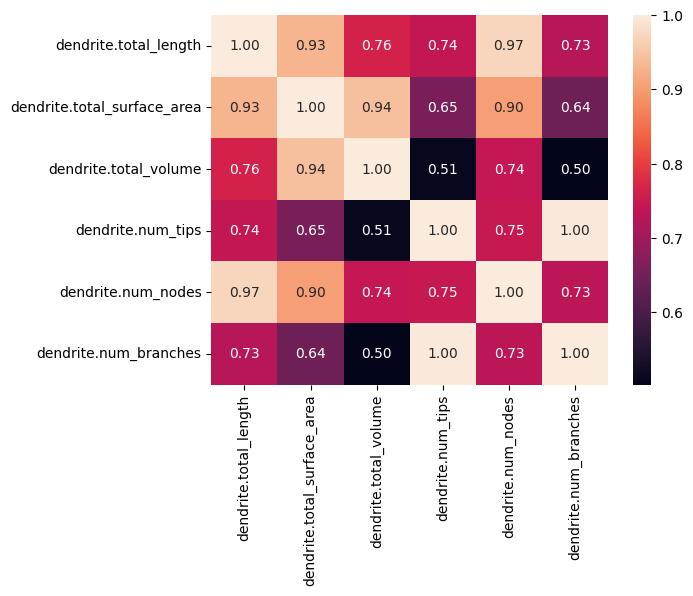

In [ ]:
#Computing correlation heatmap for each dendrite feature.
sns.heatmap(cell_data[[col for col in cell_data.columns if col.startswith("dendrite")]].corr(), annot=True, fmt=".2f", annot_kws={"fontsize":10})

<Axes: xlabel='dendrite.num_branches', ylabel='dendrite.total_length'>

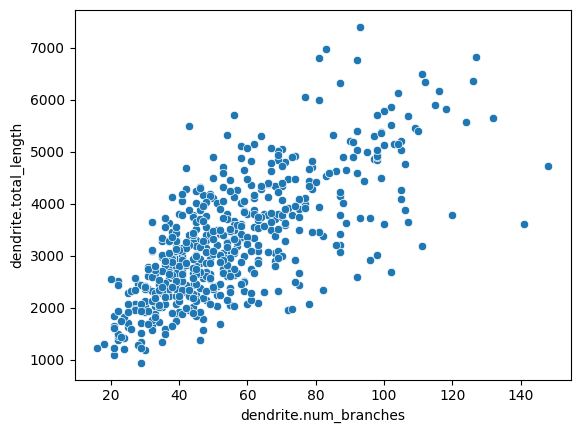

In [ ]:
sns.scatterplot(x=cell_data["dendrite.num_branches"], y=cell_data["dendrite.total_length"])

We can get an overview and summary statistics of the data using `df.describe()`

In [ ]:
cell_data["dendrite.num_branches"].describe()

,dendrite.num_branches
count,573.000000
mean,55.265271
std,22.805949
min,16.000000
25%,39.000000
50%,50.000000
75%,68.000000
max,148.000000


We can see that the most highly branched neuron has 148 branches, while the least has 16. The mean number of branches is 55.27 with a standard deviation of 22.81, indicating that the data is somewhat close to the mean.

The histogram below shows the distribution of dendrite.num_branches. As you can see, it is partially right-skewed.

<Axes: xlabel='dendrite.num_branches', ylabel='Count'>

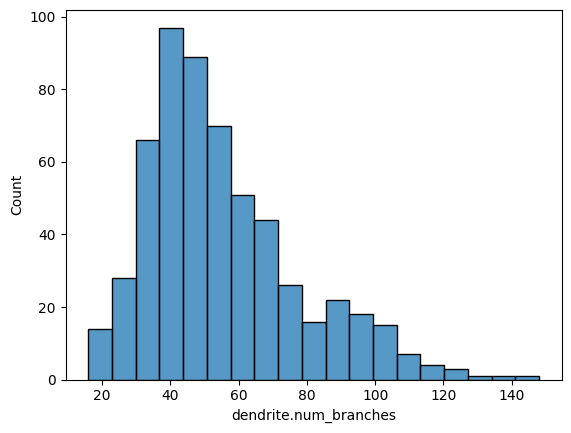

In [ ]:
sns.histplot(cell_data["dendrite.num_branches"])

Next, we should determine if there is NA or missing data using `.isna()` and `.any()`.

In [ ]:
cell_data["dendrite.num_branches"].isna().any()

np.False_

We can see there is no missing data for dendrite.num_branches; however, we should also verify this for the gene expression data, which can be accessed using `cell_data.iloc[:, :-24]`.

In [ ]:
cell_data.iloc[:, :-24].isna().any().any()

np.False_

We should also examine the metadata, specifically neuron_reconstruction_type, to check the morphological data for any anomalies. First we combine `cell_data` and `cell_metadata` to get the metadata for the specific neurons in `cell_data`, as `cell_metadata` includes data for other neurons without morphological reconstructions. Printing the columns shows that the metadata is now included.

In [ ]:
cell_data = cell_data.join(cell_metadata, how="inner")
cell_data.columns

Index(['0610005C13Rik', '0610006L08Rik', '0610007P14Rik', '0610009B22Rik',
       '0610009E02Rik', '0610009L18Rik', '0610009O20Rik', '0610010B08Rik',
       '0610010F05Rik', '0610010K14Rik',
       ...
       'apical_dendrite_status', 'neuron_reconstruction_type',
       'cell_soma_normalized_depth', 'depth_from_pia_um', 'ephys_session_id',
       'transcriptomics_sample_id', 'transcriptomics_batch',
       'T-type Accession ID', 'T-type Label', 'MET-type Label'],
      dtype='object', length=45814)

In [ ]:
cell_data["neuron_reconstruction_type"].value_counts()

,count
neuron_reconstruction_type,
full,528
dendrite-only,45


By looking at the different reconstruction types, we can see that the majority of neurons have full reconstructions, while some have reconstructions of the dendrites only. Because we are focusing on dendritic morphology, these reconstructions should not affect the analysis. However, the histogram below shows that the distribution of these two reconstruction types are different. Interestingly, the dendrite-only reconstructions generally have higher numbers of branches. Investigation into the original paper and the Allen Institute website did not yield any insights into this.

<Axes: xlabel='dendrite.num_branches', ylabel='Count'>

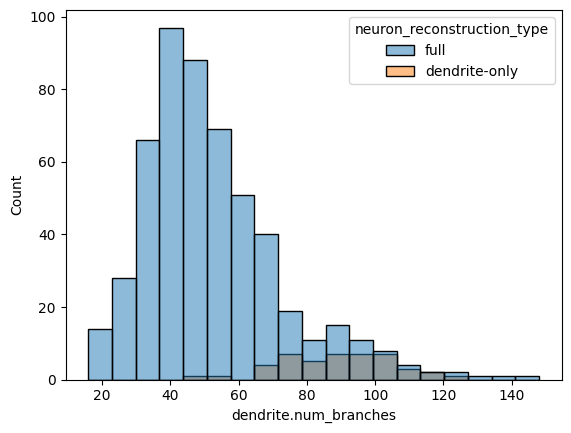

In [ ]:
sns.histplot(data=cell_data, x='dendrite.num_branches', hue='neuron_reconstruction_type')

##GSEA Setup: The Ranking Metric and Ranked List of Genes

The first step of GSEA requires a list of all the genes in the dataset ranked by a suitable metric. There are multiple different metrics that can be used depending on the type of data, but the metric should ultimately reflect the correlation between a gene's expression level and the phenotype. GSEA is most often applied to datasets with two distinct classes or experimental conditions (e.g. normal cells vs. diseased cells) to identify pathways that are upregulated in one class/condition compared to the other. In that case, metrics based on the differential expression of each gene between the two classes is used, such as the signal-to-noise ratio, t-test, or fold change. For this analysis, we are analyzing a continuous phenotype where there are not two distinct classes. Therefore, we will use the Pearson correlation coefficent as our ranking metric instead.

In [ ]:
 #Computing correlations between each gene with dendritic branching.
corrs = cell_data.iloc[:, :-46].corrwith(cell_data["dendrite.num_branches"])

#Ranking the list with the most correlated genes at the top.
corrs = corrs.sort_values(ascending=False)
corrs.head(7)

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,0
Arpp21,0.512190
Slc17a7,0.508691
Cacna2d1,0.499428
Ptprd,0.491913
R3hdm1,0.487666
Phactr1,0.482130
Nell2,0.480631


A positive correlation indicates that a gene tends to be more expressed as the number of branches increase, suggesting that it is involved in promoting dendritic branching. Below are scatterplots of the top 2 genes:

<Axes: xlabel='Arpp21', ylabel='dendrite.num_branches'>

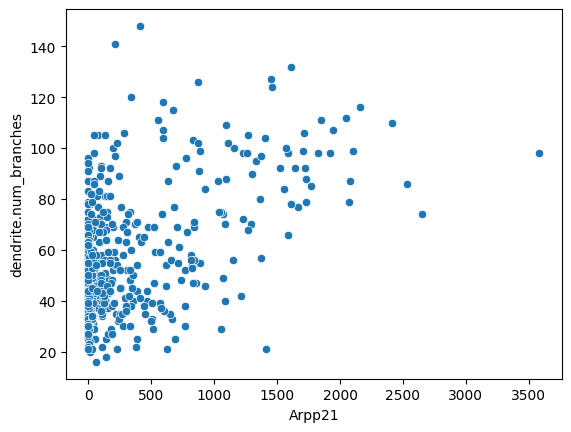

In [ ]:
sns.scatterplot(x=cell_data["Arpp21"], y=cell_data["dendrite.num_branches"])

<Axes: xlabel='Slc17a7', ylabel='dendrite.num_branches'>

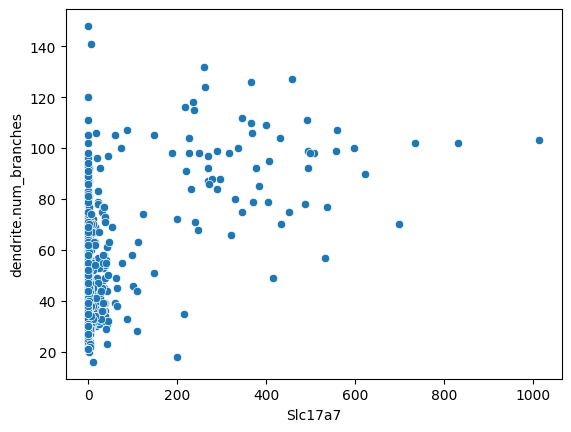

In [ ]:
sns.scatterplot(x=cell_data["Slc17a7"], y=cell_data["dendrite.num_branches"])

In [ ]:
corrs.tail(7)

,0
n-R5s139,NaN
n-R5s141,NaN
n-R5s142,NaN
n-R5s143,NaN
n-R5s144,NaN
n-R5s146,NaN
n-R5s149,NaN


As we can see by printing the tail of `corrs`, some genes have NaN correlation values. This is because these genes are not expressed in any sample in the dataset, and thus there is no spread in the expression data (standard deviation = 0), resulting in an undefined value. These genes will not be relevant for the analysis and can be removed from the ranked list `corrs`.

In [ ]:
corrs = corrs.dropna()
corrs.tail(7)

,0
Ube3a,-0.296282
Dpp6,-0.299590
Rab3b,-0.300480
Elavl2,-0.300543
Grip1,-0.303891
Kcnc2,-0.304194
Gria1,-0.315897


A negative correlation indicate that a gene is involved in the inhibition or downregulation of dendritic branching. Here are the scatterplots of the bottom 2 genes:

<Axes: xlabel='Gria1', ylabel='dendrite.num_branches'>

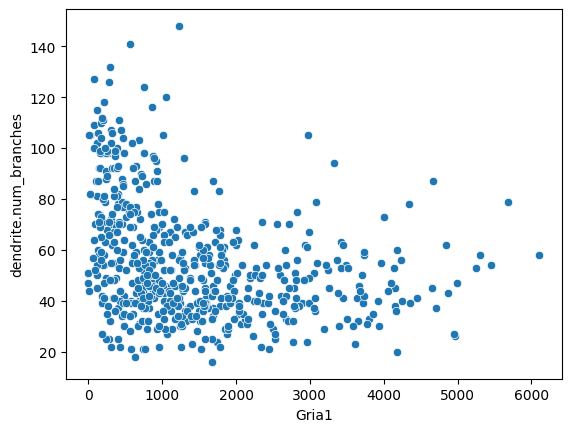

In [ ]:
sns.scatterplot(x=cell_data["Gria1"], y=cell_data["dendrite.num_branches"])

<Axes: xlabel='Kcnc2', ylabel='dendrite.num_branches'>

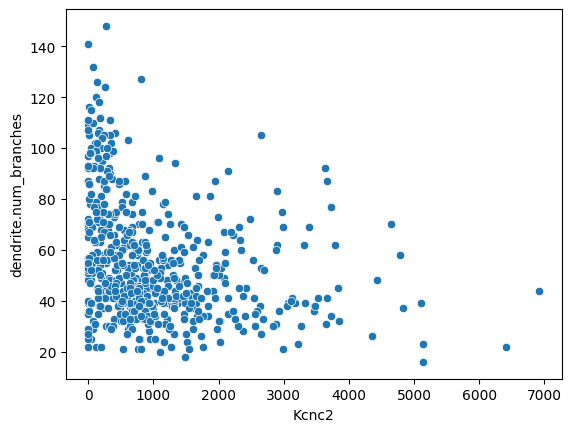

In [ ]:
sns.scatterplot(x=cell_data["Kcnc2"], y=cell_data["dendrite.num_branches"])

Now that we have a ranked list of correlations, GSEA can determine which gene sets from a database are most associated (both positively and negatively) with dendritic branches based on the individual correlations of the set's constituent genes. GSEA calculates an enrichment score (ES) for each gene set, which, in this case, represents the correlation of the gene set with dendritc branching.

<Axes: ylabel='corr_val'>

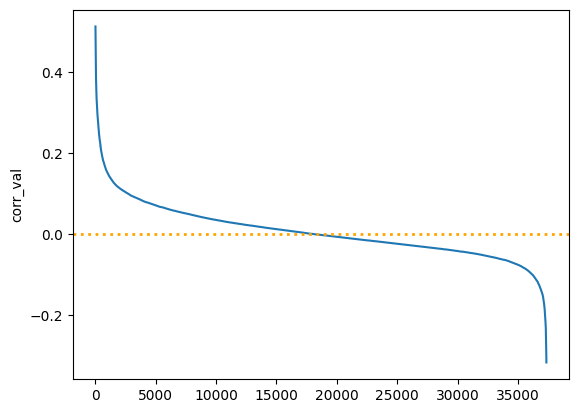

In [ ]:
corrs = corrs.reset_index() #Resetting index to access the index as a column
corrs.columns = ["gene", "corr_val"]
corrplt = sns.lineplot(corrs["corr_val"]) #Showing how correlation value changes with gene rank
corrplt.axhline(y=0, linewidth=2, color='orange', ls=':')
corrplt

This line graph shows the correlation values of the genes. The x-axis is the rank of the gene within the sorted list. As this graph shows, the very extremes of the ranked list have relatively high correlations, which rapidly decline beyond  within the first 1000 genes. The GSEA algorithm weights the contribution of each gene to the ES based its correlation value, so low correlation genes will not affect the score a pathway receives too greatly, while highly correlated genes will have a larger impact.

#Gene Set Enrichment Analysis (GSEA)

##Selecting a Gene Set Database and Converting Gene Symbols

Next, we need to select gene set databases to analyze. GSEApy provides access to the [Enrichr](https://maayanlab.cloud/Enrichr/#libraries) and Molecular Signatures Database ([MSigDB](https://www.gsea-msigdb.org/gsea/msigdb)) APIs, which both hold a variety of gene set databases. MSigDB is the database collection introduced with the original GSEA paper (Subramanian et al., 2005), and has separate mouse and human databases. Enrichr merges mouse, human and rat data as described [here](https://pmc.ncbi.nlm.nih.gov/articles/PMC4987924/).

Gene symbols will also be important depending on the database you choose.
Mouse gene symbols generally have the first letter capitalized (e.g. Arpp21), whereas human gene symbols have all letters capitalized (ARPP21). In Enrichr, for example, gene symbols are all uppercase, so the mouse gene symbols in this data need to be converted. Many orthologous genes between mice and humans share the same gene symbol, however there are also some exceptions (see https://academic.oup.com/molehr/pages/Gene_And_Protein_Nomenclatue or https://www.jci.org/kiosk/publish/genestyle). While you can just capitalize every gene symbol, it is better to map the genes by orthology. Genes are often converted for less-studied species that don't have gene set databases specific to them.

*Mus musculus* is one of the most common model organisms so there are many mouse-specific gene set databases and collections. We will use MSigDB for the analysis below.

###MSigDB

The Molecular Signatures Database (MSigDB) is a collection of gene sets and gene set databases created for the GSEA algorithm. It is divided into mouse and human-specific sections. It has a number of [gene set collections](https://www.gsea-msigdb.org/gsea/msigdb/mouse/collections.jsp?targetSpeciesDB=Mouse#MH), but we will focus on M2 curated gene sets and M5 ontology gene sets, as some of these were used in the original analysis found in my research poster. The other collections can be useful for specific purposes like finding transcriptional targets or cancer-specific gene sets. The curated collection has gene sets from commonly used pathway databases and online sources, such as [Reactome](https://reactome.org/) and [WikiPathways](https://www.wikipathways.org/). M5 also has the [Gene Ontology](https://geneontology.org/) (GO) sets. To access MSigDB, GSEApy provides methods to see and load the files; alternatively, you can download the .gmt files directly from the website.




In [ ]:
from gseapy import Msigdb
msigdb = Msigdb()

#See all versions of MSigDB
msigdb.list_dbver()

,Name,Last modified
0,6.0,2018-12-17 16:29
1,6.1,2018-12-17 16:29
2,6.2,2018-12-17 16:29
3,7.0,2020-01-27 04:43
4,7.1,2020-03-30 16:55
5,7.2,2020-09-18 23:33
6,7.3,2021-03-22 15:09
7,7.4,2021-04-02 14:38
8,7.5.1,2023-03-09 19:38
9,7.5,2022-01-13 01:00


In [ ]:
# list categories given version
msigdb.list_category(dbver="2024.1.Mm") # mouse

['m1.all',
 'm2.all',
 'm2.cgp',
 'm2.cp.biocarta',
 'm2.cp.reactome',
 'm2.cp',
 'm2.cp.wikipathways',
 'm3.all',
 'm3.gtrd',
 'm3.mirdb',
 'm5.all',
 'm5.go.bp',
 'm5.go.cc',
 'm5.go.mf',
 'm5.go',
 'm5.mpt',
 'm8.all',
 'mh.all',
 'msigdb']

##Functions for GSEA and Visualizations

GSEApy provides a few different functions to perform the analysis (see the developmental guide [here](https://gseapy.readthedocs.io/en/latest/run.html)), including `gp.gsea()` and `gp.prerank()`. `gp.gsea()` only supports categorical data and specific ranking metrics based on differential expression. Since we're analyzing continuous data, we'll use `gp.prerank()`, which allows us to pre-rank the genes using our own ranking metric, Pearson correlation. This is an example of the .prerank() function:


```
output = gp.prerank(rnk=corrs, gene_sets= .gmt file or Enrichr database name)
```

We can also use `gseaplot()` to create a gsea plot which shows the distribution of the gene set across the ranked list, the ES calculation, and other key statistics for a given set.

```
gseaplot(term="gene set name", rank_metric=output.ranking, **output.results["gene set name"])
```

We'll also write a function that creates a network visualization of the results using `enrichment_map()`. Each node represents a gene set with the color representing the NES. The width of the edges connecting each node indicates the similarity of the gene sets based on the [Jaccard coefficient](https://en.wikipedia.org/wiki/Jaccard_index), which measures the similarity of two sets. This graph will alllow us to vizualize the connections between the enriched gene sets.





In [ ]:
#Code adapted from example in documentation: https://gseapy.readthedocs.io/en/latest/gseapy_example.html#Prerank-example

def network_visualization(output, col = "FDR q-val", top_term = 20, cutoff=0.05, k = None, dimensions = (7, 7), title = None):
  '''
  output: Output object from gp.prerank()
  col" The column the nodes will be based on. To show most significant results use: "Adjusted P-value", "P-value", "FDR q-val", or "NOM p-val". To show results based on NES, use "NES".
  top_term: The number of gene sets you want to graph
  cut_off: The cutoff for the significance value
  k: The k parameter for the spring layout as described in the networkx documentation. Adjust this value to change node spacing. https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
  dimensions: The dimensions of the graph as a tuple
  title: Title of the visualization (e.g. "Reactome")
  '''

  nodes, edges = enrichment_map(output.res2d, column = col, cutoff = cutoff, top_term = top_term)

  #Creates a graph, G. The source and targets columns of the edges dataframe define node connections and edge_attr specifies attributes for the edges.
  G = nx.from_pandas_edgelist(edges,
                            source="src_idx",
                            target="targ_idx",
                            edge_attr=["jaccard_coef", "overlap_coef", "overlap_genes"])

  #Added this code to add any missing nodes.
  for node in nodes.index:
        if node not in G:
            G.add_node(node)

  fig, ax = plt.subplots(figsize = dimensions)

  # init node coordinates with spring layout
  pos=nx.layout.spring_layout(G, k = k)

  # draws the nodes
  nx.draw_networkx_nodes(G,
                        pos=pos,
                        cmap=plt.cm.RdYlBu if col in ["Adjusted P-value", "P-value", "FDR q-val", "NOM p-val"] else plt.cm.Blues,# Use plt.cm.RdYlBu if the enrichment_map() column argument is FDR q-val. Use plt.cm.Blues if you set it to NES.
                        nodelist=nodes.index, #This fixed the node coloring issue. This puts the nodes in the correct order.
                        node_color=list(nodes.NES),
                        node_size=list(nodes.Hits_ratio *1000)
                        )

  # draws the node labels
  nodes["term_shortened"] = nodes.Term.apply(lambda x: "_".join(x.split()[:4]) if len(x.split()) <= 5 else f"{'_'.join(x.split()[:4])}...") #Makes shortened terms with 5 words or less If it was longer than 5 originally it adds ...
  nx.draw_networkx_labels(G,
                          pos=pos,
                          labels=nodes["term_shortened"].to_dict(),
                          font_size=10) #nodes.Term.to_dict()
  # draws the edges
  edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
  nx.draw_networkx_edges(G,
                        pos=pos,
                        width=list(map(lambda x: x*10, edge_weight)),
                        edge_color='#CDDBD4')
  plt.title(title)
  plt.show()

  print(nodes.Term)


Once you run `gp.prerank()`, you can show the most positively and negatively enriched gene sets. Here are the key output statistics:
*   "Term": The gene set.
*   "ES": The enrichment score representing how correlated the gene set is with dendritic branching.
*   "NES": The normalized enrichment score, which is the ES normalized to the size of the set
*   "NOM p-val": The estimated p-value based on a null distribution generated using a phenotype permutation test.
*   "FDR q-val": The false discovery rate is the probability that the gene set is a false positive finding, and is used to correct for multiple hypothesis testing. It represents the average proportion of results that are false positives. If you get 100 significant results at q < 0.05, 5 results are expected to be false.
*   "FWER p-val": The probability of at least one false positive result among all the results. This is a more conservative or stringent measure than FDR.
*   "Tag %": The percentage of genes that contribute to the ES (the genes in the set before the peak of the ES running-sum calculation for positive results and after for negative)
*   "Gene %": The percentage of genes in the entire ranked list before (for positive results) or after (for negative results) the peak of the running ES. This indicates where in the ranked list the ES was attained.
*   "Lead_genes": The genes in the leading-edge subset of the set, which will be explained further down.

More details can be found in the [paper](https://www.pnas.org/doi/10.1073/pnas.0506580102), [GSEA documentation and user guide](https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html), and [GSEApy documentation](https://gseapy.readthedocs.io/en/latest/introduction.html).

In the next section, we'll go through an example using each of these functions.

##Reactome

###Running the Analysis

We'll first run the analysis with the [Reactome](https://reactome.org/) pathway database.

In [ ]:
reactome_out = gp.prerank(rnk=corrs, gene_sets=msigdb.get_gmt(category="m2.cp.reactome", dbver="2024.1.Mm"))
reactome_res = reactome_out.res2d.sort_values(by="NES",ascending=False).reset_index(drop=True) #Sorting by NES

2025-05-22 12:29:51,232 [WARNING] Duplicated values found in preranked stats: 4.24% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Below are the gene sets that are most correlated with the number of dendritic branches.

In [ ]:
reactome_res.head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,REACTOME_NONSENSE_MEDIATED_DECAY_NMD_INDEPENDE...,0.632828,2.318418,0.0,0.0,0.0,76/95,30.13%,Rps14;Pabpc1;Rplp2;Rpl31;Rpl9;Rpl37a;Rpl32;Rps...
1,prerank,REACTOME_EUKARYOTIC_TRANSLATION_INITIATION,0.580016,2.179755,0.0,0.000882,0.002,70/120,24.16%,Rps14;Pabpc1;Rplp2;Rpl31;Rpl9;Eif3f;Eif4a1;Eif...
2,prerank,REACTOME_NONSENSE_MEDIATED_DECAY_NMD,0.578566,2.178842,0.0,0.000588,0.002,73/114,23.99%,Rps14;Pabpc1;Rplp2;Rpl31;Rpl9;Rpl37a;Ppp2r2a;R...
3,prerank,REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_O...,0.614076,2.082631,0.0,0.001544,0.005,36/60,24.16%,Rps14;Pabpc1;Eif3f;Eif4a1;Eif4ebp1;Rps16;Rps6;...
4,prerank,REACTOME_CA2_PATHWAY,0.648309,2.079753,0.0,0.001235,0.005,16/45,11.39%,Ppp3ca;Calm1;Nlk;Calm2;Camk2a;Ppp3r1;Fzd3;Calm...
5,prerank,REACTOME_PROTEIN_PROTEIN_INTERACTIONS_AT_SYNAPSES,0.607693,2.066339,0.0,0.001618,0.009,25/61,11.23%,Ptprd;Nlgn1;Sorbs2;Dlg1;Il1rap;Grin2a;Homer1;D...
6,prerank,REACTOME_UNBLOCKING_OF_NMDA_RECEPTORS_GLUTAMAT...,0.734266,2.046338,0.0,0.002017,0.013,13/22,8.18%,Dlg1;Lrrc7;Grin2a;Calm1;Nefl;Calm2;Camk2a;Calm...
7,prerank,REACTOME_RAF_INDEPENDENT_MAPK1_3_ACTIVATION,0.74627,2.045592,0.0,0.001765,0.013,10/22,8.53%,Dusp6;Dusp7;Dusp5;Map2k1;Dusp4;Mapk1;Il6ra;Jak...
8,prerank,REACTOME_ACTIVATION_OF_NMDA_RECEPTORS_AND_POST...,0.668371,2.02597,0.0,0.002549,0.021,17/35,8.18%,Dlg1;Lrrc7;Grin2a;Camkk2;Calm1;Nefl;Calm2;Camk...
9,prerank,REACTOME_ION_HOMEOSTASIS,0.600478,2.004678,0.0,0.002647,0.025,20/52,5.92%,Atp2b1;Atp1a1;Itpr1;Atp2b2;Atp2b4;Fxyd7;Calm1;...


These are the gene sets most negatively correlated with dendritic branching.

In [ ]:
reactome_res.tail(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
752,prerank,REACTOME_TRAFFICKING_OF_GLUR2_CONTAINING_AMPA_...,-0.572765,-1.663771,0.030303,0.138371,0.79,6/16,4.39%,Gria1;Grip1;Grip2;Pick1;Prkcg;Gria4
753,prerank,REACTOME_PROCESSING_OF_INTRONLESS_PRE_MRNAS,-0.544442,-1.673554,0.008929,0.133692,0.76,8/20,10.39%,Pabpn1;Cstf2;Sympk;Cpsf6;Cpsf3;Nudt21;Ncbp2;Cpsf4
754,prerank,REACTOME_GABA_SYNTHESIS_RELEASE_REUPTAKE_AND_D...,-0.5341,-1.681875,0.01506,0.133201,0.743,9/19,5.38%,Cplx1;Slc32a1;Gad1;Gad2;Abat;Rab3a;Slc6a1;Aldh...
755,prerank,REACTOME_INSULIN_RECEPTOR_RECYCLING,-0.496141,-1.728002,0.006849,0.098006,0.633,14/29,19.96%,Atp6ap1;Atp6v0c;Atp6v1g2;Atp6v1h;Atp6v0b;Atp6v...
756,prerank,REACTOME_SYNTHESIS_OF_VERY_LONG_CHAIN_FATTY_AC...,-0.567664,-1.728578,0.008646,0.103627,0.631,6/18,2.48%,Tecr;Acsl6;Hsd17b12;Elovl5;Acsl3;Acsl1
757,prerank,REACTOME_BIOSYNTHESIS_OF_THE_N_GLYCAN_PRECURSO...,-0.411162,-1.770326,0.0,0.076917,0.499,23/73,9.91%,St8sia1;Alg2;St6galnac5;Glb1;Gmds;Cmas;Slc35a1...
758,prerank,REACTOME_CONVERSION_FROM_APC_C_CDC20_TO_APC_C_...,-0.580703,-1.814578,0.006042,0.055613,0.365,10/20,25.39%,Anapc4;Fzr1;Ube2d1;Anapc7;Ube2c;Anapc1;Anapc2;...
759,prerank,REACTOME_TRANSFERRIN_ENDOCYTOSIS_AND_RECYCLING,-0.511394,-1.826616,0.0,0.053064,0.331,16/31,19.96%,Atp6ap1;Atp6v0c;Atp6v1g2;Atp6v1h;Atp6v0b;Atp6v...
760,prerank,REACTOME_GLUCONEOGENESIS,-0.588734,-1.875272,0.003257,0.037092,0.233,17/23,24.74%,Pck2;Slc37a1;Gpi1;Eno2;Tpi1;Slc37a4;Gapdh;G6pc...
761,prerank,REACTOME_MATURATION_OF_TCA_ENZYMES_AND_REGULAT...,-0.637542,-1.901044,0.0,0.031417,0.186,9/16,12.50%,Fxn;Nfs1;Sdha;Acat1;Iscu;Lyrm4;Isca1;Sdhd;Sdhaf2


You can look up each results to get more details on the pathway. The Reactome website displays a diagram of the pathway, a description, and literature references. Here is an example for the top gene set: [Nonsense Mediated Decay (NMD) independent of the Exon Junction Complex (EJC)](https://reactome.org/content/detail/R-HSA-975956). Before we do more detailed research into the results, we can use some visualizations to get a broader understanding the data and focus our later research.

###Visualizations for the Reactome Results

First, we have a GSEA plot which shows a diagram for an individual pathway. This is useful for visualizing the algorithm and the ES score.

[<Axes: xlabel='Gene Rank', ylabel='Ranked metric'>,
 <Axes: >,
 <Axes: >,
 <Axes: ylabel='Enrichment Score'>]

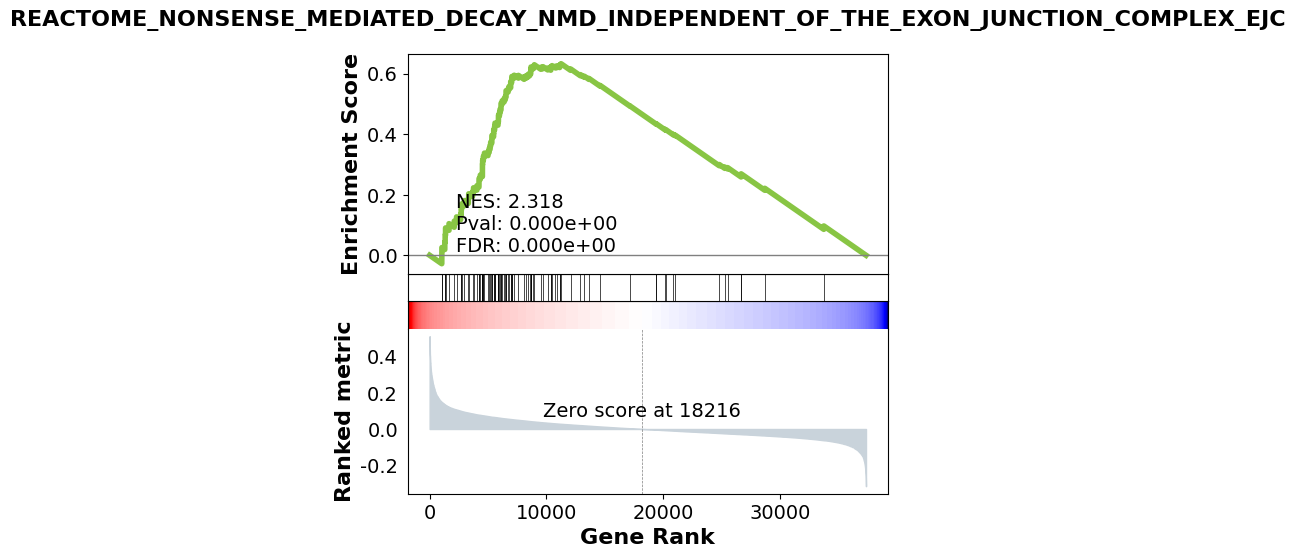

In [ ]:
gseaplot(term=reactome_res.loc[0]["Term"], rank_metric=reactome_out.ranking, **reactome_out.results[reactome_res.loc[0]["Term"]])

The dark lines in the horizontal strip show where each gene in the gene set is found in the ranked list. You can see the many of the genes in this gene set are near the top of the ranked list (they concentrate near the left side), indicating that many of the genes are postively correlated with dendritic branching. Even though none of the genes are in the top ~500 of the ranked list, the pathway as a whole is upregulated. This is a good example of how GSEA leverages pathway information to find results that might be hidden to a simple single gene analysis. We can also see the key statistics including NES, nominal p-value, and FDR, which are summarized in the results dataframe.

Next is the network visualization function which was created above. Each node represents a gene set with the color representing the NES. The width of the edges connecting each node indicates the similarity of the gene sets based on the Jaccard coefficient. This will allow us to visualize the connections between the gene sets and overall patterns in our results. Blue represents positive correlation, and red represents negative, but you can adjust the color mapping used in the code.

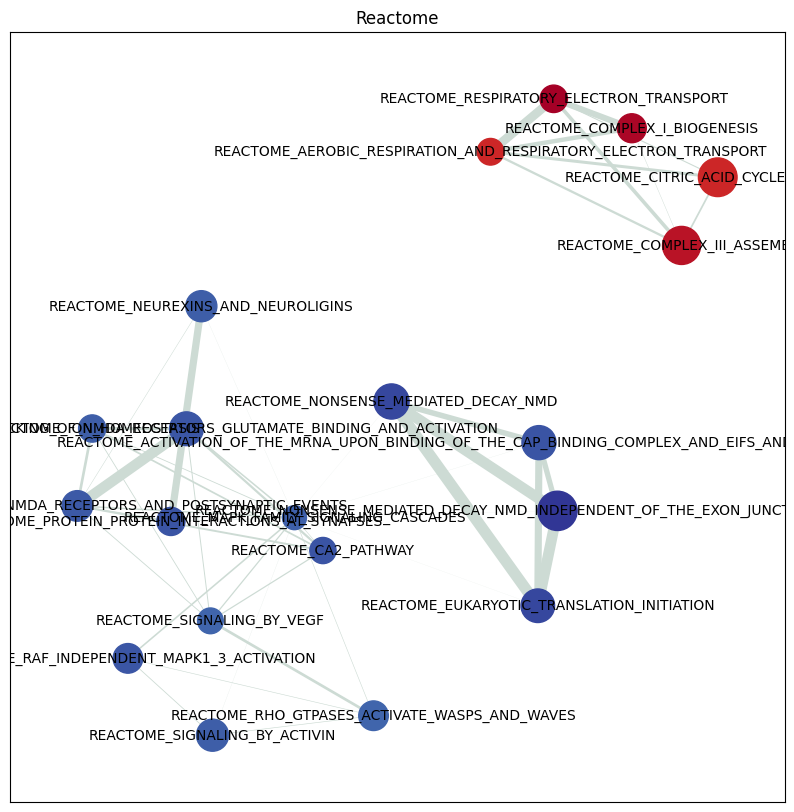

node_idx
0         REACTOME_RHO_GTPASES_ACTIVATE_WASPS_AND_WAVES
1                            REACTOME_SIGNALING_BY_VEGF
2               REACTOME_MAPK_FAMILY_SIGNALING_CASCADES
3                         REACTOME_SIGNALING_BY_ACTIVIN
4                    REACTOME_NEUREXINS_AND_NEUROLIGINS
5                              REACTOME_ION_HOMEOSTASIS
6     REACTOME_ACTIVATION_OF_NMDA_RECEPTORS_AND_POST...
7     REACTOME_UNBLOCKING_OF_NMDA_RECEPTORS_GLUTAMAT...
8           REACTOME_RAF_INDEPENDENT_MAPK1_3_ACTIVATION
9     REACTOME_PROTEIN_PROTEIN_INTERACTIONS_AT_SYNAPSES
10    REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_O...
11                                 REACTOME_CA2_PATHWAY
12           REACTOME_EUKARYOTIC_TRANSLATION_INITIATION
13                 REACTOME_NONSENSE_MEDIATED_DECAY_NMD
14    REACTOME_NONSENSE_MEDIATED_DECAY_NMD_INDEPENDE...
15                        REACTOME_COMPLEX_III_ASSEMBLY
16    REACTOME_AEROBIC_RESPIRATION_AND_RESPIRATORY_E...
17                        REACTOME_COMP

In [ ]:
network_visualization(reactome_out, col = "FDR q-val", top_term = 20, cutoff=0.05, k = 1, dimensions = (10, 10), title = "Reactome")

 For this network graph, the top 20 gene sets are shown, but you can also set a signficance cutoff. As you can see, there is a group of negatively correlated gene sets that are all related to cellular respiration/mitochondria (oxidative phosphorylation and the citric acid cycle). One of the positively correlated group is related mainly to gene expression (mRNA translation and NMD). The third group has a variety of gene sets related to neuronal signaling, including NMDA receptor (a glutamate-activated calcium channel) pathways, MAPK-related pathways, synapse interactions, cytoskeletal/actin regulation, and more. Below, we will do more detailed analysis of these results.

#Leading-Edge Subset Analysis

Next, we will analyze the leading-edge subsets of the enriched gene sets to identify important genes. The paper defines the leading-edge subset as follows:
> "We define the leading-edge subset to be those genes in the gene set S that appear in the ranked list L at, or before, the point where the running sum reaches its maximum deviation from zero ( Fig. 1B). The leading-edge subset can be interpreted as the core of a gene set that accounts for the enrichment signal." (Subramanian et al., 2005)
![Leading-edge on GSEA plot](https://github.com/rcs-science-research/Dendritic-Branching-GSEA/blob/main/Supplementary%20Materials%20and%20Images/Leading-Edge%20Subset%20Marked%20on%20GSEA%20Plot%20Example.png?raw=true)

On the GSEA plot above, for example, the leading edge genes are the ones in the shaded red box. These are the genes before and at the maximum ES.
The leading-edge genes are the most biologically relevant within the gene set because they account for the ES that the set obtains. We can cluster the significant gene sets based on the similarity of their leading edges to create groups that have common biological function. If the leading-edge subsets of two gene sets are similar, they likely correspond to the same or a related process. We can also examine the gene overlap of all the leading-edge subsets in a cluster to find individual genes that are centrally important in that cluster (Subramanian et al., 2005).


##Clustering and Visualization Functions

We will use agglomerative hierarchical clustering to cluster our gene sets based on leading edge similarity. The Jaccard coefficient is used as a metric of gene membership similarity. Agglomerative hierarchical clustering is a bottom-up approach that groups similar data points (gene sets) into a hierarchy of clusters. Each data point is initially treated as an individual cluster and then the algorithm iteratively merges the closest pair based on a distance metric (jaccard in this case) and linkage criterion/method. The distance metric (jaccard) is used to determine the distance between individual gene sets, whereas the linkage method determines the distance between two sub-clusters of gene sets.

In [ ]:
#Based on https://rdrr.io/bioc/GSEAmining/src/R/gm_clust.R
def cluster_results(output, gene_sets):
  '''
  output: output object from gp.prerank()
  gene_sets: The gene sets to be clustered inputted as a list.
  '''

  res_df = output.res2d
  res_df = res_df.loc[res_df["Term"].isin(gene_sets)] #Getting the gene sets the user wants to analyze

  #Creating the document term matrix (dtm), which indicates whether each gene is present for each gene set.
  vectorizer = CountVectorizer(tokenizer=lambda x: x.split(";"), token_pattern=None)
  X = vectorizer.fit_transform(res_df["Lead_genes"])
  dtm = pd.DataFrame(X.toarray(), index=res_df["Term"], columns=vectorizer.get_feature_names_out())

  #Creating the distance matrix, computes pairwise Jaccard distance (similarity) between gene sets.
  distance_matrix = pdist(dtm, metric="jaccard")
  #distanceMatrixDF = pd.DataFrame(squareform(distance_matrix), index=dtm.index, columns=dtm.index) #For visualization

  '''
  While "jaccard" is used to determine how similar individual pairs of gene sets are, the method parameter or linkage criterion determines how similar (or dissimilar) sub-clusters are to each other in order to correctly merge them. Some common methods are "single", "complete", "average", "centroid", "median", or "ward". The choice of linkage criterion will affect the clusters the hierarchy that is created. Here, "average" is used.
  '''
  linkage_matrix = linkage(distance_matrix, method="average")

  return linkage_matrix, dtm, distance_matrix, res_df

Hierarchical clustering outputs a hierarchical structure with different clusters at each level, so we need to flatten this hierarchy into one set of clusters. Depending on where we "cut" the dendrogram, the clusters will be different. In the function below, the [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering) is used to determine the optimal threshold. However, the threshold can be adjusted to create more general or more specific clusters. There are also different linkage methods such as single, complete, average, and Ward linkage that affect how the gene sets are clustered. Average linkage (which is used here) determines the average pairwise jaccard distance between two clusters of gene sets, whereas Ward linkage minimizes the total within-cluster variance, and generally produces more compact, evenly sized clusters. The linkage method or cut threshold can be changed depending on the specific goal of clustering (more general vs. more specific, for example).

In [ ]:
def flat_clusters(linkage_matrix, dtm, res_df): #Finds the optimal threshold based on silhouette score and creates flat clusters.

  unique_dists = np.unique(linkage_matrix[:,2]) #Finds all the unique distances where there are distinct combinations of clusters.
  max_silhouette = -1
  optimal_clusters = None
  optimal_threshold = None

  #Iterates over all unique thresholds.
  for threshold in unique_dists:
    cluster_ids = fcluster(linkage_matrix,t=threshold, criterion='distance') #Creates flat clusters at the current threshold.
    if len(np.unique(cluster_ids)) > 1:
      score = silhouette_score(dtm, cluster_ids, metric='jaccard')
      print(f"Score: {score}, threshold: {threshold}")
      if score > max_silhouette: #Find the highest silhouette score
        max_silhouette=score
        optimal_clusters=cluster_ids
        optimal_threshold=threshold
  print(f"OPTIMAL - Score: {max_silhouette}, threshold: {optimal_threshold}")

  clusters_df = res_df
  clusters_df["Cluster_id"] = optimal_clusters #Creating a new column with cluster ids for each gene set.
  clusters_df.reset_index()
  clusters_df = clusters_df.groupby(["Cluster_id"]) #Grouping the gene sets into their clusters.

  clusters= []
  for cluster_id, gene_sets in clusters_df:
    clusters.append(gene_sets["Term"].to_list())

  return clusters, optimal_threshold

This function generates a comprehensive report with key statistics and graphs. In addition to the clusters, we can create a dendrogram to visualize the hierarchical structure. We can also calculate the frequency of each gene within a cluster. A gene that appears in many of the gene sets of a cluster is likely to be important.

In [ ]:
def generate_leading_edge_report(output, gene_sets, results, db_name):
  linkage_matrix, dtm, distance_matrix, res_df = cluster_results(output, gene_sets)
  clusters, optimal_threshold = flat_clusters(linkage_matrix, dtm, res_df)

  #Display cluster summaries with constituent gene sets, average NES, and cluster size.
  for cluster in clusters:
    if len(cluster) > 1:
      nes_sum = 0
      print("_____________________________")
      for term in cluster:
        nes_sum += res_df.loc[res_df["Term"] == term]["NES"].values[0]
      mean_nes = nes_sum/len(cluster)
      print(cluster)
      print(f"Average NES: {mean_nes}")
      print(f"Cluster Size: {len(cluster)}")

  #Generates dendrogram to vizualize hierarchical clustering.
  plt.figure(figsize=(8, 5))
  #labels are shortened. Color indicates the flat clusters
  dendrogram(linkage_matrix, labels=dtm.index.map(lambda x: " ".join(x.split()[:4]) if len(x.split()) <= 5 else f"{' '.join(x.split()[:4])}..."), leaf_rotation=90, color_threshold=optimal_threshold)
  plt.title(f"{db_name} Gene Sets Dendrogram")
  plt.xlabel("Gene Sets")
  plt.ylabel("Distance")
  plt.xticks(fontsize=7)
  plt.show()

  dendro = dendrogram(linkage_matrix, labels=dtm.index.map(lambda x: " ".join(x.split()[:4]) if len(x.split()) <= 5 else f"{' '.join(x.split()[:4])}..."), leaf_rotation=90, color_threshold=optimal_threshold, no_plot=True) #labels are shortened.

  #Creating a dictionary mapping the colors and gene set names (term). This is to match the color of the gene frequency bar graph with the automatic coloring in the dendrogram.
  cluster_colors = {term_label: color for term_label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}

  x=0

  for cluster in clusters:
    if len(cluster) > 1:
      gene_counter = {} #Counts the frequency of each gene
      for term in cluster:
        for gene in output.results[term]["lead_genes"].split(";"):
          if gene in gene_counter:
            gene_counter[gene] +=1
          else:
            gene_counter[gene] = 1

      sorted_counter = sorted(gene_counter.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
      top_20 = sorted_counter[:20]
      genes, occurrences = zip(*top_20)

      plt.figure(figsize=(4,5))
      sns.barplot(x=occurrences, y=genes, color=cluster_colors.get(" ".join(cluster[0].split()[:4]) if len(cluster[0].split()) <= 5 else f"{' '.join(cluster[0].split()[:4])}...", "grey"))
      plt.xlabel("Number of Gene Sets", fontsize=18)
      plt.ylabel('Genes', fontsize=17)

      plt.tick_params(axis='both', labelsize=15)
      plt.title(f"{db_name} Cluster {x}", fontsize=20)
      plt.tight_layout()
      plt.show()
      print(cluster)
      x+=1




###Reactome Example of Leadin-Edge Subset Analysis

Now, we'll run the `generate_leading_edge_report()` function for our Reactome results. The report below uses all the Reactome sets with FDR < 0.01 for simplicity, however you can adjust the signficance level. At FDR < 0.05, for example, there are 59 significant gene sets.

Score: 0.012851335824426224, threshold: 0.189873417721519
Score: 0.08140478097218823, threshold: 0.2228513356562137
Score: 0.14252279339454846, threshold: 0.23529411764705882
Score: 0.17849724758846436, threshold: 0.3611111111111111
Score: 0.2202895782633773, threshold: 0.48
Score: 0.24446165722671637, threshold: 0.5685207796318906
Score: 0.2550611083539214, threshold: 0.6215277777777778
Score: 0.23374839458911637, threshold: 0.7921146953405018


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/me

Score: 0.23929759599630887, threshold: 0.794392523364486
Score: 0.2510900676313881, threshold: 0.8048780487804879
Score: 0.260034186050134, threshold: 0.84375
Score: 0.25243991576937985, threshold: 0.8476840011366865
Score: 0.2544827200506203, threshold: 0.8590229885057471
Score: 0.2539796493069273, threshold: 0.8922495848021164
Score: 0.26090878518631205, threshold: 0.8957217624148004
Score: 0.24693296344399798, threshold: 0.953723993917693
Score: 0.2025368878756748, threshold: 0.9628258780826305
Score: 0.20750089174500222, threshold: 0.9725439498816936
Score: 0.20263084891207744, threshold: 0.9820334830543078
Score: 0.18046938371634144, threshold: 0.9832137434784256
Score: 0.08633589879818007, threshold: 0.9994794398960768
OPTIMAL - Score: 0.26090878518631205, threshold: 0.8957217624148004
_____________________________
['REACTOME_RESPIRATORY_ELECTRON_TRANSPORT', 'REACTOME_COMPLEX_I_BIOGENESIS', 'REACTOME_COMPLEX_III_ASSEMBLY', 'REACTOME_CITRIC_ACID_CYCLE_TCA_CYCLE', 'REACTOME_AEROBIC

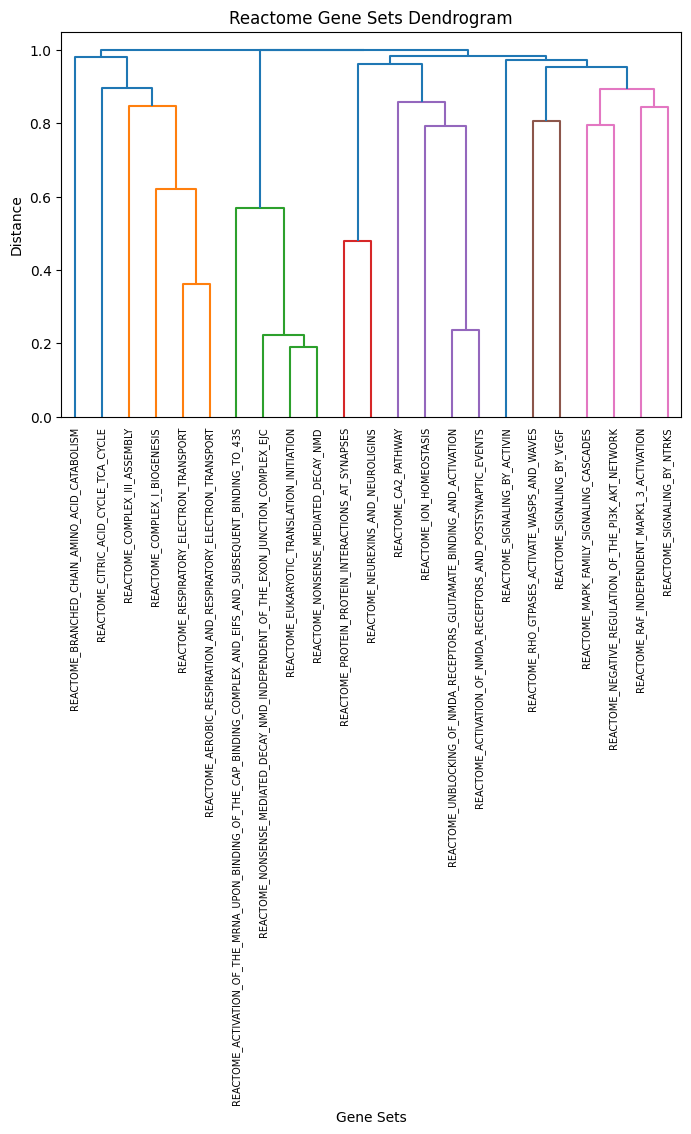

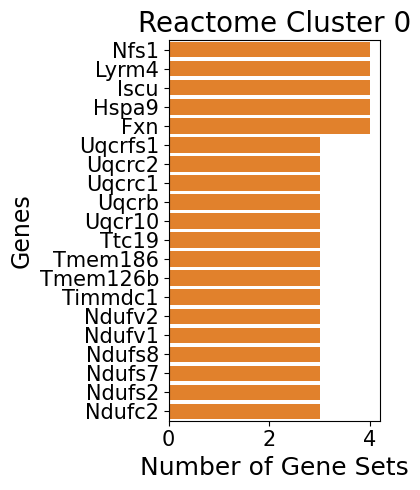

['REACTOME_RESPIRATORY_ELECTRON_TRANSPORT', 'REACTOME_COMPLEX_I_BIOGENESIS', 'REACTOME_COMPLEX_III_ASSEMBLY', 'REACTOME_CITRIC_ACID_CYCLE_TCA_CYCLE', 'REACTOME_AEROBIC_RESPIRATION_AND_RESPIRATORY_ELECTRON_TRANSPORT']


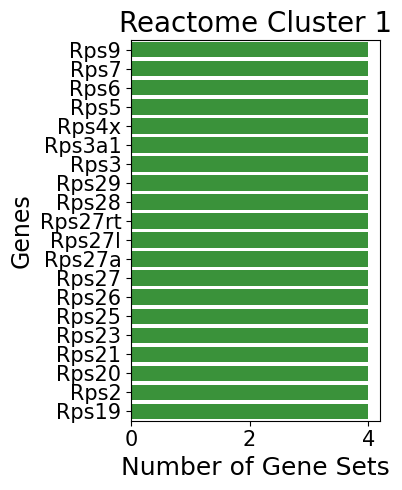

['REACTOME_NONSENSE_MEDIATED_DECAY_NMD_INDEPENDENT_OF_THE_EXON_JUNCTION_COMPLEX_EJC', 'REACTOME_EUKARYOTIC_TRANSLATION_INITIATION', 'REACTOME_NONSENSE_MEDIATED_DECAY_NMD', 'REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_OF_THE_CAP_BINDING_COMPLEX_AND_EIFS_AND_SUBSEQUENT_BINDING_TO_43S']


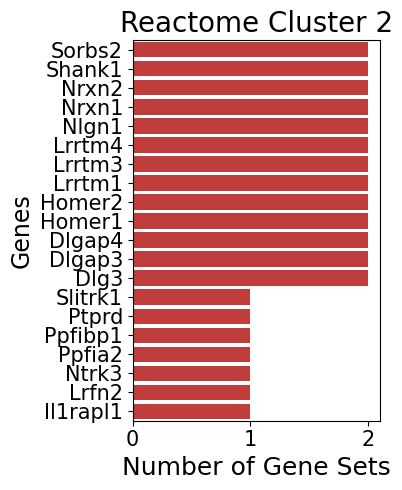

['REACTOME_PROTEIN_PROTEIN_INTERACTIONS_AT_SYNAPSES', 'REACTOME_NEUREXINS_AND_NEUROLIGINS']


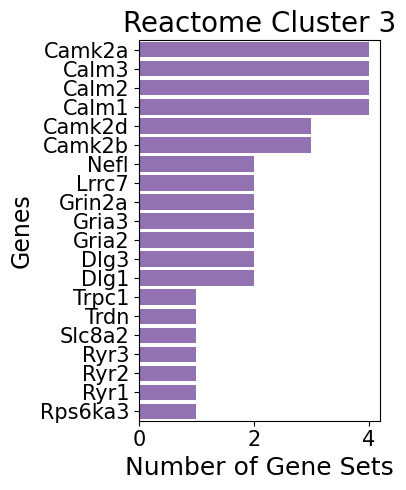

['REACTOME_CA2_PATHWAY', 'REACTOME_UNBLOCKING_OF_NMDA_RECEPTORS_GLUTAMATE_BINDING_AND_ACTIVATION', 'REACTOME_ACTIVATION_OF_NMDA_RECEPTORS_AND_POSTSYNAPTIC_EVENTS', 'REACTOME_ION_HOMEOSTASIS']


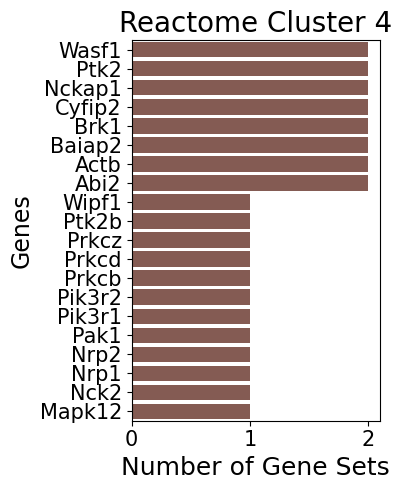

['REACTOME_RHO_GTPASES_ACTIVATE_WASPS_AND_WAVES', 'REACTOME_SIGNALING_BY_VEGF']


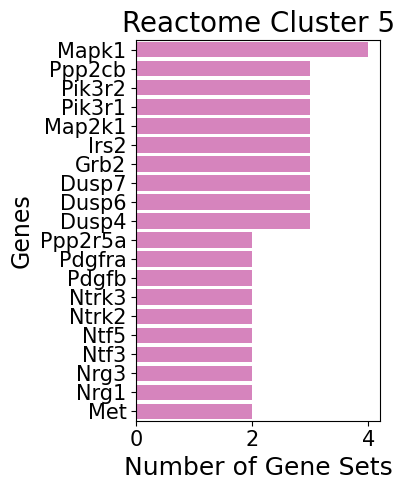

['REACTOME_RAF_INDEPENDENT_MAPK1_3_ACTIVATION', 'REACTOME_MAPK_FAMILY_SIGNALING_CASCADES', 'REACTOME_SIGNALING_BY_NTRKS', 'REACTOME_NEGATIVE_REGULATION_OF_THE_PI3K_AKT_NETWORK']


In [ ]:
generate_leading_edge_report(reactome_out, reactome_res.loc[reactome_res["FDR q-val"] < 0.01]["Term"], reactome_res, "Reactome")

From the dendrogram, we can see that there are some nicely defined clusters, with several 4-gene set groupings. The orange cluster (cluster 0) consists of many of the negatively correlated gene sets. Closer examination reveals that these are the pathways for the enzyme complexes in the electron transport chain (ETC) of cellular respiration/mitochondria. The other negatively correlated sets are related to different parts of cellular respiration such as the citric acid cycle. This suggests a negative relationship between mitochondria/cellular respiration and dendritic branching, which will be further examined below.

The green cluster has many positive sets related to gene expression, inlcuding mRNA translation and nonsense mediated decay (NMD). There are many genes that participated in all of the sets, so there isn't much insight from the bar graph.

For the purple cluster 3, there were two NMDA receptor pathways (the NMDAR is a glutatmate-receptor calcium channel), and two related to calcium/ions. Here is the Reactome page for
[REACTOME_ACTIVATION_OF_NMDA_RECEPTORS_AND_POSTSYNAPTIC_EVENTS](https://reactome.org/PathwayBrowser/#/R-HSA-442755). Activation of the NMDA receptor allows calcium influx into the intracellular environment, which modulates various activity/calcium-dependent signaling cascades (Wong & Ghosh, 2002) related to calcium/calmodulin-dependent protein kinases (CaMKs) and MAPK signaling. The other calcium pathway in this cluster, [REACTOME_CA2_PATHWAY](https://reactome.org/content/detail/R-HSA-4086398), is another intracellular calcium release pathway. In this pathway, extracellular signals such as WNT proteins and also glutamate act through G protein signaling to cleave the PIP2 phospholipid into DAG and IP3. IP3 signaling activates calcium release into the cytosol from the endoplasmic reticulum, also leading to downstream CaMK signaling (Hagenston & Bading, 2011). Looking at the bar graph, we see multiple CaMKII isoforms, as well as Calm1, 2, 3, which are calmodulin genes; this suggests that CaMK signaling is a central pathway within this cluster. Calmodulin binds cytosolic calcium (from NMDARs for example), which then activates CaMKs. CaMKII specifically has been shown to modulates local branch dynamics via cytoskeletal changes (Konur & Ghosh, 2005; Wu et al., 2001).

Another pathway activated by intracellular calcium is Ras/MAPK signaling. This cascade, along with CaMKIV (another type of CaMK), leads to phosphorylation of the transcription factor CREB, which modulates gene expression important to global dendritic growth (Konur & Ghosh, 2005; Wu et al., 2001). The pink cluster had two MAPK related gene sets, and the Mapk1 gene was present in all four pathways in the cluster.


![](https://github.com/rcs-science-research/Dendritic-Branching-GSEA/blob/main/Supplementary%20Materials%20and%20Images/Graphical%20Abstract%20Final%20Version.jpeg?raw=true)

##Gene Ontology (GO) Biological Process

Another database we'll use is [Gene Ontology](https://geneontology.org/docs/ontology-documentation/), which organizes its representation in three classes. Biological process (BP) encompasses large-scale processes consisting of multiple or many molecular interactions. Molecular Function (MF) represents processes at the molecular level involving individual gene products (e.g. proteins) or complexes of gene products. Cellular Component (CC) corresponds mainly to cellular anatomical structures and features.

We'll first run the analysis with GO BP to see large scale biological processes in our data.

In [ ]:
gobp_out = gp.prerank(rnk=corrs, gene_sets=msigdb.get_gmt(category="m5.go.bp", dbver="2024.1.Mm"))
gobp_res = gobp_out.res2d.sort_values(by="NES",ascending=False).reset_index(drop=True) #Sorting by NES

2025-05-22 13:08:38,076 [WARNING] Duplicated values found in preranked stats: 4.24% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [ ]:
gobp_res.head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GOBP_POSTSYNAPSE_ASSEMBLY,0.658187,2.339649,0.0,0.0,0.0,26/83,4.26%,Ptprd;Nlgn1;Ptk2b;Sipa1l1;Numb;Lzts1;Rtn4r;Il1...
1,prerank,GOBP_REGULATION_OF_POSTSYNAPSE_ORGANIZATION,0.596376,2.321602,0.0,0.0,0.0,54/170,6.95%,Ptprd;Nlgn1;Ptk2b;Itpka;Epha4;Kalrn;Baiap2;Nge...
2,prerank,GOBP_POSTSYNAPTIC_SPECIALIZATION_ASSEMBLY,0.72111,2.303534,0.0,0.0,0.0,18/43,4.26%,Ptprd;Nlgn1;Ptk2b;Sipa1l1;Il1rap;Ntng2;Abi3bp;...
3,prerank,GOBP_POSITIVE_REGULATION_OF_EXCITATORY_POSTSYN...,0.715581,2.288984,0.0,0.0,0.0,17/40,5.44%,Nlgn1;Ptk2b;Baiap2;Stx1a;Cux2;Grin2a;Rgs4;Nrxn...
4,prerank,GOBP_REGULATION_OF_POSTSYNAPTIC_SPECIALIZATION...,0.806218,2.284796,0.0,0.0,0.0,13/25,4.26%,Ptprd;Nlgn1;Ptk2b;Sipa1l1;Il1rap;Abi3bp;Nrxn1;...
5,prerank,GOBP_POSTSYNAPTIC_SPECIALIZATION_ORGANIZATION,0.672143,2.251233,0.0,0.000341,0.002,25/62,5.44%,Ptprd;Nlgn1;Ptk2b;Cnksr2;Sipa1l1;Il1rap;Ntng2;...
6,prerank,GOBP_POSTSYNAPSE_ORGANIZATION,0.555903,2.238684,0.0,0.000292,0.002,102/278,11.56%,Ptprd;Nlgn1;Ptk2b;Itpka;Epha4;Cnksr2;Kalrn;Bai...
7,prerank,GOBP_REGULATION_OF_DENDRITIC_SPINE_MORPHOGENESIS,0.661438,2.22891,0.0,0.000255,0.002,22/59,6.95%,Nlgn1;Itpka;Epha4;Kalrn;Baiap2;Ngef;Sipa1l1;Cu...
8,prerank,GOBP_POSTSYNAPTIC_DENSITY_ASSEMBLY,0.734712,2.226546,0.0,0.000227,0.002,14/33,4.26%,Ptprd;Nlgn1;Ptk2b;Sipa1l1;Il1rap;Abi3bp;C1ql3;...
9,prerank,GOBP_REGULATION_OF_SYNAPSE_STRUCTURE_OR_ACTIVITY,0.541438,2.210477,0.0,0.000204,0.002,114/359,9.26%,Slc17a7;Ptprd;Nlgn1;Ptk2b;Itpka;Bdnf;Neurod2;E...


We can see that there are many gene sets related to postsynaptic assembly and organization, including dendritic spines morphogenesis, as well as one related to regulation of the actin cytoskeleton, which is crucial to the formation and remodeling of dendrites (and neuronal structure in general). This is good confirmation that our methodology is correctly identifying pathways involved in dendritic growth. You might notice that many of the gene sets are very similar, such as POSTSYNAPSE_ASSEMBLY, POSTSYNAPTIC_SPECIALIZATION_ASSEMBLY, or POSTSYNAPSE_ORGANIZATION. This is because Gene Ontology is based on a hierarchical structure, where a GO child term is a more specialized or specific version of its parent term, resulting in redundant results in some cases.

In [ ]:
gobp_res.tail(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
4152,prerank,GOBP_METALLO_SULFUR_CLUSTER_ASSEMBLY,-0.641618,-2.070615,0.0,0.008595,0.151,10/21,9.22%,Fxn;Nfs1;Ciapin1;Abcb7;Hspa9;AK157302;Iscu;Lyr...
4153,prerank,GOBP_GAMMA_AMINOBUTYRIC_ACID_TRANSPORT,-0.606029,-2.075061,0.0,0.008608,0.146,8/25,4.59%,Sv2a;Trpc4;Slc32a1;Abat;Slc7a14;Grik1;Slc6a1;H...
4154,prerank,GOBP_BRANCHED_CHAIN_AMINO_ACID_METABOLIC_PROCESS,-0.610746,-2.083972,0.0,0.007795,0.127,10/25,7.63%,Bckdhb;Bcat1;Hibadh;Dld;Acat1;Ilvbl;Acadsb;Auh...
4155,prerank,GOBP_LYSOSOMAL_LUMEN_ACIDIFICATION,-0.70791,-2.089851,0.0,0.007379,0.116,8/15,12.54%,Atp6ap2;Atp6v0c;Lamp1;Tmem106b;Tmem9;Ppt1;Snap...
4156,prerank,GOBP_POSITIVE_REGULATION_OF_MEMBRANE_POTENTIAL,-0.657783,-2.091533,0.0,0.00784,0.116,10/22,14.58%,Gria1;Mfn1;Tmem135;Ndufc2;Vcp;Glrx;Akt1;Drd1;B...
4157,prerank,GOBP_ATP_BIOSYNTHETIC_PROCESS,-0.488327,-2.095282,0.0,0.007929,0.112,25/69,13.34%,Ndufs2;Slc25a12;Ndufv2;Ndufa8;Ndufs7;Sdha;Nduf...
4158,prerank,GOBP_ATP_SYNTHESIS_COUPLED_ELECTRON_TRANSPORT,-0.505884,-2.100194,0.0,0.008164,0.107,29/64,13.21%,Ndufs2;Cyc1;Ndufv2;Uqcrc1;Cox6a2;Cox7b;Ndufa8;...
4159,prerank,GOBP_PROTEIN_CATABOLIC_PROCESS_IN_THE_VACUOLE,-0.64402,-2.107591,0.0,0.008006,0.097,9/22,8.81%,Laptm4b;Psap;Atp13a2;Cd81;Vps35;Tcirg1;Ldlr;Tm...
4160,prerank,GOBP_CELLULAR_RESPIRATION,-0.410004,-2.112559,0.0,0.008131,0.091,70/202,13.34%,Ndufs2;Slc25a12;Mdh1;Tmem135;Cyc1;Idh3a;Ndufv2...
4161,prerank,GOBP_OXIDATIVE_PHOSPHORYLATION,-0.468422,-2.136287,0.0,0.006251,0.063,41/110,13.34%,Ndufs2;Tmem135;Cyc1;Ndufv2;Uqcrc1;Cox6a2;Cox7b...


The negatively correlated results also concur with our results from Reactome. Most of the pathways are related to mitochondria/cellular respiration, and specifcally the ETC and TCA cycle. Below is the leading edge analysis report for GO BP, Since the BP gene sets are more general and there are some redundant results, we won't go into detailed analysis; however you can see some common genes with our Reactome results.

###GO BP Leading Edge Analysis

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/me

Score: 0.024104683195592284, threshold: 0.09090909090909091
Score: 0.0580152171061262, threshold: 0.1
Score: 0.06999868818050636, threshold: 0.13636363636363635
Score: 0.09908959727141546, threshold: 0.15
Score: 0.12296572114753933, threshold: 0.15384615384615385
Score: 0.14984134624788772, threshold: 0.19320214669051877
Score: 0.15489185129839278, threshold: 0.19871794871794873
Score: 0.16896111536765684, threshold: 0.2
Score: 0.1870656291830744, threshold: 0.2222222222222222
Score: 0.21515003651167583, threshold: 0.22727272727272727
Score: 0.2371441714090365, threshold: 0.25806451612903225
Score: 0.24867310030730022, threshold: 0.2832722832722832
Score: 0.2571626348292486, threshold: 0.33333333333333337
Score: 0.24873412377645865, threshold: 0.35916666666666663
Score: 0.25987669244124034, threshold: 0.4
Score: 0.2752164178200282, threshold: 0.421875
Score: 0.2839209999511838, threshold: 0.4326923076923077
Score: 0.2943268389526991, threshold: 0.44656905594405594
Score: 0.299674432535

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/me

Score: 0.3467023286451155, threshold: 0.5496794871794872
Score: 0.3558820718996104, threshold: 0.6743488395662309
Score: 0.33400619669937204, threshold: 0.7175993167930562
Score: 0.3348402799255478, threshold: 0.7507744238093873
Score: 0.34085750547737187, threshold: 0.7512472283813748
Score: 0.34859802834516795, threshold: 0.7607554490738649
Score: 0.34595541730859547, threshold: 0.8666433855560379
Score: 0.2659764709804498, threshold: 0.8925617847517089
Score: 0.2685022688558047, threshold: 0.9090909090909091
Score: 0.2189503036135611, threshold: 0.917577638989575
Score: 0.22188738665162233, threshold: 0.9466666666666667
Score: 0.21769659478279635, threshold: 0.9504238083186427
Score: 0.20878792796728443, threshold: 0.9557467386414755
Score: 0.17461639903176362, threshold: 0.9726390641103078
Score: 0.1769711971697994, threshold: 0.978077478077478
Score: 0.1717451008061954, threshold: 0.9812814751290543
Score: 0.12908182707056867, threshold: 0.9896383518323315
OPTIMAL - Score: 0.35588

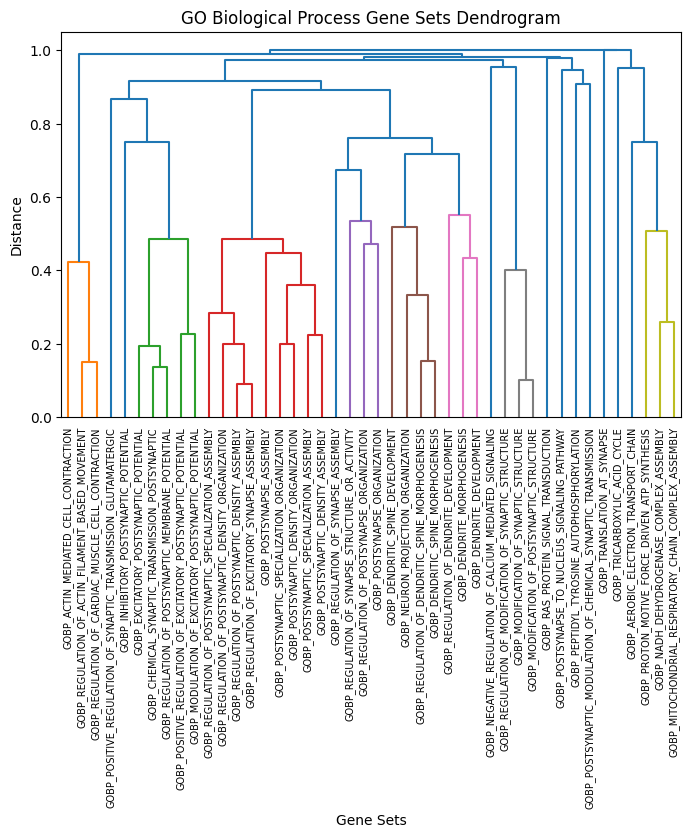

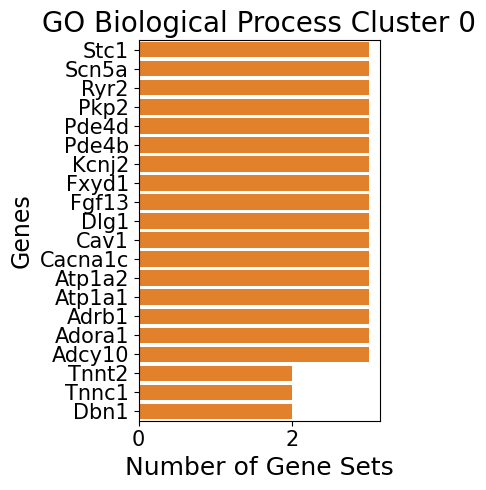

['GOBP_REGULATION_OF_ACTIN_FILAMENT_BASED_MOVEMENT', 'GOBP_REGULATION_OF_CARDIAC_MUSCLE_CELL_CONTRACTION', 'GOBP_ACTIN_MEDIATED_CELL_CONTRACTION']


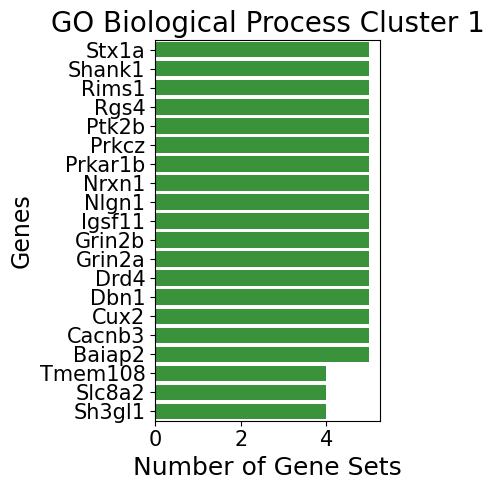

['GOBP_POSITIVE_REGULATION_OF_EXCITATORY_POSTSYNAPTIC_POTENTIAL', 'GOBP_CHEMICAL_SYNAPTIC_TRANSMISSION_POSTSYNAPTIC', 'GOBP_EXCITATORY_POSTSYNAPTIC_POTENTIAL', 'GOBP_MODULATION_OF_EXCITATORY_POSTSYNAPTIC_POTENTIAL', 'GOBP_REGULATION_OF_POSTSYNAPTIC_MEMBRANE_POTENTIAL']


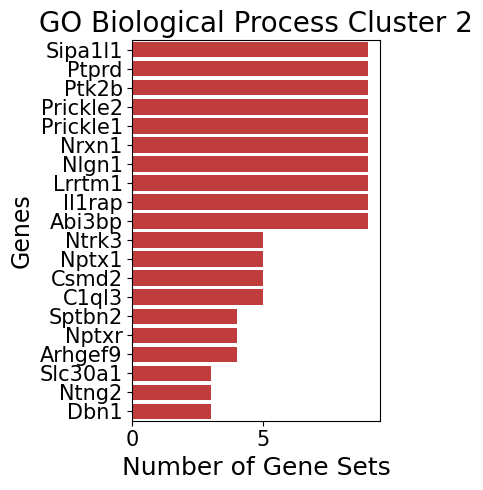

['GOBP_POSTSYNAPSE_ASSEMBLY', 'GOBP_POSTSYNAPTIC_SPECIALIZATION_ASSEMBLY', 'GOBP_REGULATION_OF_POSTSYNAPTIC_SPECIALIZATION_ASSEMBLY', 'GOBP_POSTSYNAPTIC_SPECIALIZATION_ORGANIZATION', 'GOBP_POSTSYNAPTIC_DENSITY_ASSEMBLY', 'GOBP_REGULATION_OF_POSTSYNAPTIC_DENSITY_ORGANIZATION', 'GOBP_POSTSYNAPTIC_DENSITY_ORGANIZATION', 'GOBP_REGULATION_OF_POSTSYNAPTIC_DENSITY_ASSEMBLY', 'GOBP_REGULATION_OF_EXCITATORY_SYNAPSE_ASSEMBLY']


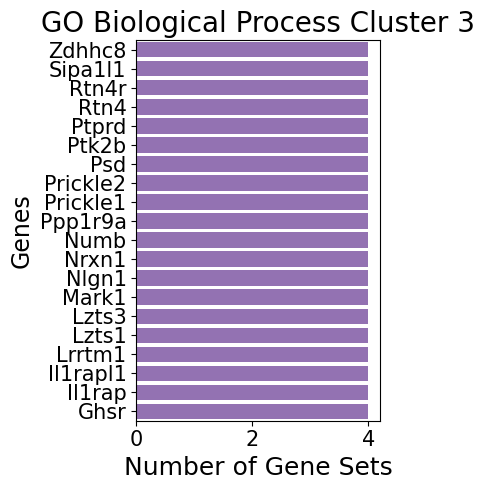

['GOBP_REGULATION_OF_POSTSYNAPSE_ORGANIZATION', 'GOBP_POSTSYNAPSE_ORGANIZATION', 'GOBP_REGULATION_OF_SYNAPSE_STRUCTURE_OR_ACTIVITY', 'GOBP_REGULATION_OF_SYNAPSE_ASSEMBLY']


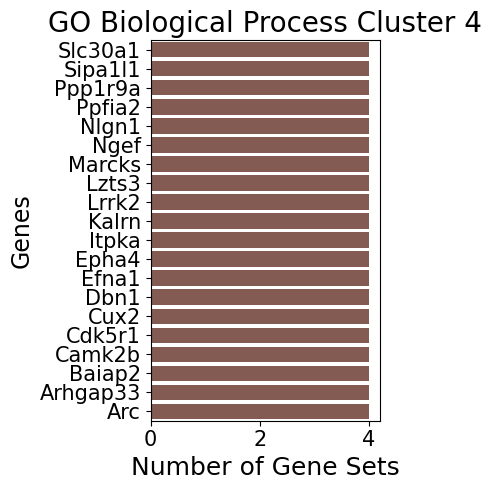

['GOBP_REGULATION_OF_DENDRITIC_SPINE_MORPHOGENESIS', 'GOBP_DENDRITIC_SPINE_MORPHOGENESIS', 'GOBP_DENDRITIC_SPINE_DEVELOPMENT', 'GOBP_NEURON_PROJECTION_ORGANIZATION']


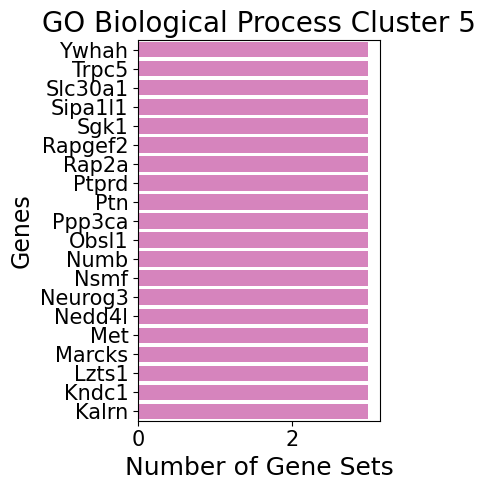

['GOBP_REGULATION_OF_DENDRITE_DEVELOPMENT', 'GOBP_DENDRITE_MORPHOGENESIS', 'GOBP_DENDRITE_DEVELOPMENT']


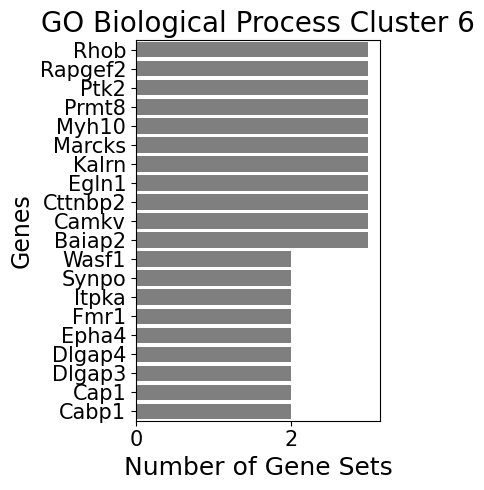

['GOBP_REGULATION_OF_MODIFICATION_OF_SYNAPTIC_STRUCTURE', 'GOBP_MODIFICATION_OF_SYNAPTIC_STRUCTURE', 'GOBP_MODIFICATION_OF_POSTSYNAPTIC_STRUCTURE']


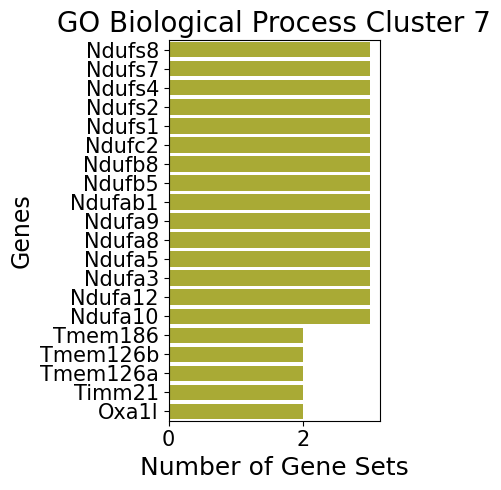

['GOBP_NADH_DEHYDROGENASE_COMPLEX_ASSEMBLY', 'GOBP_MITOCHONDRIAL_RESPIRATORY_CHAIN_COMPLEX_ASSEMBLY', 'GOBP_PROTON_MOTIVE_FORCE_DRIVEN_ATP_SYNTHESIS']


In [ ]:
generate_leading_edge_report(gobp_out, gobp_res.loc[gobp_res["FDR q-val"] < 0.001]["Term"], gobp_res, "GO Biological Process")

##GO Molecular Function

Next, we'll use the GO Molecular Function collection to get more specific results.

In [ ]:
gomf_out = gp.prerank(rnk=corrs, gene_sets=msigdb.get_gmt(category="m5.go.mf", dbver="2024.1.Mm"))
gomf_res = gomf_out.res2d.sort_values(by="NES",ascending=False).reset_index(drop=True) #Sorting by NES

2025-05-22 13:27:01,850 [WARNING] Duplicated values found in preranked stats: 4.24% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [ ]:
gomf_res.head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GOMF_CALMODULIN_DEPENDENT_PROTEIN_KINASE_ACTIVITY,0.764845,2.157162,0.0,0.0,0.0,11/24,5.74%,Ptk2b;Itpka;Camkk2;Camk4;Camk2a;Camkv;Camk2d;C...
1,prerank,GOMF_PHOSPHATIDYLINOSITOL_3_KINASE_BINDING,0.655651,2.093646,0.0,0.002298,0.004,17/43,8.49%,Atp1a1;Ptk2;Calm1;Tyro3;Calm2;Igf1r;Calm3;Pik3...
2,prerank,GOMF_SCAFFOLD_PROTEIN_BINDING,0.564339,2.034012,0.0,0.005821,0.018,30/84,12.44%,Nlgn1;Baiap2;Grin2a;Homer1;Dlgap3;Atp2b4;Dynll...
3,prerank,GOMF_E_BOX_BINDING,0.60438,2.014716,0.0,0.005974,0.025,16/54,7.97%,Neurod2;Neurod1;Bhlhe22;Neurod6;Bhlhe40;Ciart;...
4,prerank,GOMF_CALMODULIN_BINDING,0.512531,2.013063,0.0,0.00478,0.025,45/189,7.76%,Arpp21;Nrgn;Slc24a4;Itpka;Atp2b1;Ppp3ca;Myh7;A...
5,prerank,GOMF_CALCIUM_CHANNEL_REGULATOR_ACTIVITY,0.63449,2.006823,0.0,0.004289,0.027,18/41,10.10%,Stx1a;Itpr1;Calm1;Pde4b;Nrxn1;Cacnb3;Calm2;Grm...
6,prerank,GOMF_STRUCTURAL_CONSTITUENT_OF_SYNAPSE,0.653721,1.986082,0.0,0.006434,0.047,19/36,10.25%,Dlg1;Actn1;Homer1;Erc2;Shank2;Nefl;Rims1;Sptbn...
7,prerank,GOMF_PHOSPHATASE_INHIBITOR_ACTIVITY,0.613398,1.983063,0.0,0.00586,0.049,11/42,3.82%,Phactr1;Arpp19;Tesc;Ppp1r36;Ppp1r1b;Lmtk2;Ppp1...
8,prerank,GOMF_TRANSMEMBRANE_TRANSPORTER_BINDING,0.509579,1.978392,0.0,0.005923,0.056,46/163,8.92%,Kcnip3;Dlg1;Atp1a1;Actn1;Dpp10;Stx1a;Itpr1;Hom...
9,prerank,GOMF_CALCIUM_ION_TRANSMEMBRANE_TRANSPORTER_ACT...,0.524916,1.973743,0.0,0.005883,0.062,36/129,8.39%,Cacna2d1;Slc24a4;Atp2b1;Itpr1;Grin2a;Atp2b2;At...


The top result for GO MF is CaMK activity, along with other calcium signaling-related pathways, such as calmodulin (Calm genes) binding and various calcium channel activity gene sets. These results nicely fit with our observations from Reactome, which showed that extracellular calcium influx can activate signaling cascades related to CaMKs as well as MAPK signaling; and the MAP_KINASE_ACTIVITY pathway is also significantly enriched. There are other signficant pathways, such as ephrin signaling (also in the Reactome results) or Smad binding, but we'll mainly focus on calcium signaling here.


![](https://github.com/rcs-science-research/Dendritic-Branching-GSEA/blob/main/Supplementary%20Materials%20and%20Images/Graphical%20Abstract%20Final%20Version.jpeg?raw=true)

In [ ]:
gomf_res.tail(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
768,prerank,GOMF_SODIUM_CHANNEL_ACTIVITY,-0.444475,-1.73337,0.0,0.079139,0.677,12/43,8.14%,Grik3;Scn9a;Hcn2;Hcn1;Grik1;Scn1a;Hcn3;Pkd2;Gr...
769,prerank,GOMF_PROTEIN_DISULFIDE_ISOMERASE_ACTIVITY,-0.559535,-1.734247,0.002809,0.082782,0.675,10/19,18.94%,Enox1;Tmx1;Erp44;Txndc5;Pdia3;P4hb;Creld1;Qsox...
770,prerank,GOMF_LIPOPROTEIN_PARTICLE_RECEPTOR_BINDING,-0.498871,-1.75617,0.003584,0.072909,0.62,14/28,15.05%,App;Dnaja1;Lrpap1;Dab2;Ankra2;Lancl1;Hsp90b1;C...
771,prerank,GOMF_FERROUS_IRON_BINDING,-0.50775,-1.759513,0.013559,0.074717,0.61,11/26,12.55%,Egln3;Fxn;Th;Urod;Phyh;Tet2;Iscu;Alkbh2;Fto;Ac...
772,prerank,GOMF_UNFOLDED_PROTEIN_BINDING,-0.407233,-1.792357,0.0,0.060083,0.509,29/86,16.01%,Scg5;Canx;Cct8;Cct7;Dnaja1;Nacad;Calr;Vbp1;Tbc...
773,prerank,GOMF_PRENYLTRANSFERASE_ACTIVITY,-0.623745,-1.79268,0.0,0.063923,0.508,8/15,16.76%,Fnta;Ubiad1;Nus1;Pdss1;Ggps1;Fdps;Rabggta;Rabggtb
774,prerank,GOMF_ORGANIC_CATION_TRANSMEMBRANE_TRANSPORTER_...,-0.407247,-1.793894,0.0,0.067691,0.505,29/78,16.00%,Slc32a1;Slc3a2;Slc6a7;Slc44a5;Slc38a2;Slc38a1;...
775,prerank,GOMF_4_IRON_4_SULFUR_CLUSTER_BINDING,-0.47133,-1.819951,0.0,0.058491,0.428,18/40,15.65%,Ndufs2;Ndufs7;Ciapin1;Ndufv1;Dna2;Cdkal1;Aco1;...
776,prerank,GOMF_OXIDOREDUCTASE_ACTIVITY_ACTING_ON_NAD_P_H,-0.445785,-1.856958,0.0,0.042898,0.325,22/61,19.84%,Enox1;Ndufs2;Ndufv2;Ndufs7;Ndufa10;Ndufv1;Nduf...
777,prerank,GOMF_DISULFIDE_OXIDOREDUCTASE_ACTIVITY,-0.505104,-1.872599,0.007042,0.039581,0.279,15/35,21.47%,Tmx2;Tmx4;Tmx1;Txndc5;Pdia3;Glrx;P4hb;Gfer;Dna...


As expected, the most negatively correlated pathways are related to cellular repsiration, specifcally to oxidative phosphorylation/ETC.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/me

Score: 0.056980056980056974, threshold: 0.19444444444444445
Score: 0.09210899054649055, threshold: 0.3125
Score: 0.12643571858518612, threshold: 0.5217391304347826
Score: 0.13828044352281219, threshold: 0.575187969924812
Score: 0.1561714461357429, threshold: 0.6470588235294118
Score: 0.16905753702694887, threshold: 0.6521739130434783
Score: 0.1538929123795656, threshold: 0.7509578544061303
Score: 0.16744668481158415, threshold: 0.786231884057971
Score: 0.1787403038406552, threshold: 0.8085106382978723
Score: 0.18497640790870637, threshold: 0.8206477732793522
Score: 0.1883304737473959, threshold: 0.8398310591293048
Score: 0.1815856741178383, threshold: 0.8965867828612927
Score: 0.18495105873322293, threshold: 0.9375
Score: 0.18067884511944496, threshold: 0.9470980996404726
Score: 0.15372840148399752, threshold: 0.960439200790876
Score: 0.1410900153909142, threshold: 0.971480584035825
Score: 0.14670434568194762, threshold: 0.9764565195823754
Score: 0.1405032544193518, threshold: 0.976735

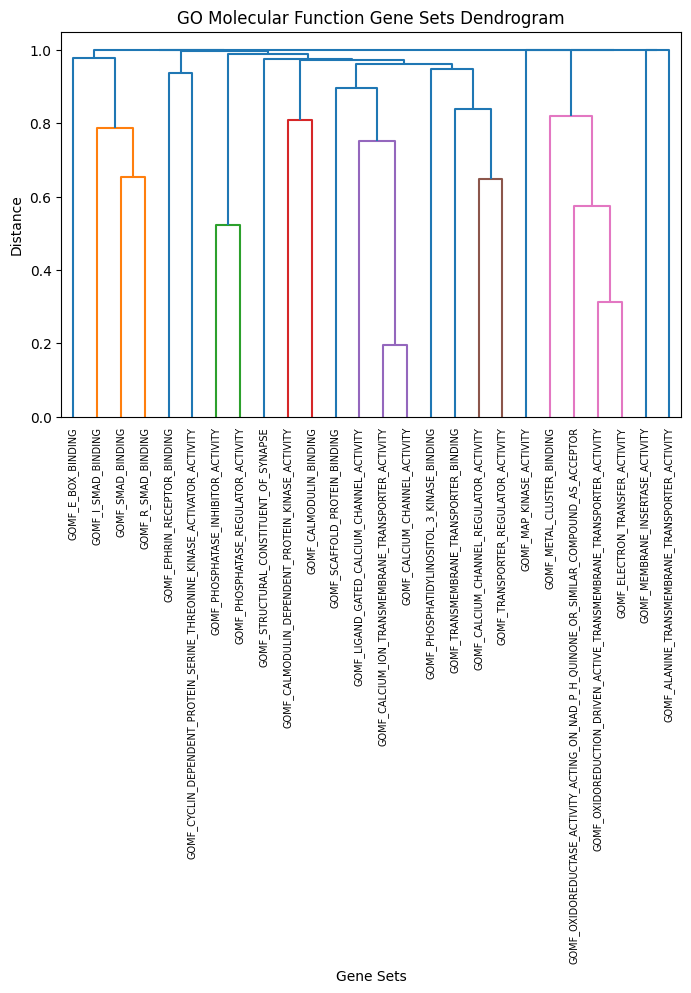

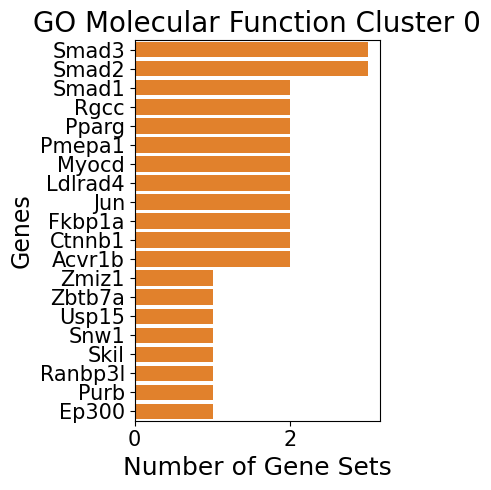

['GOMF_SMAD_BINDING', 'GOMF_R_SMAD_BINDING', 'GOMF_I_SMAD_BINDING']


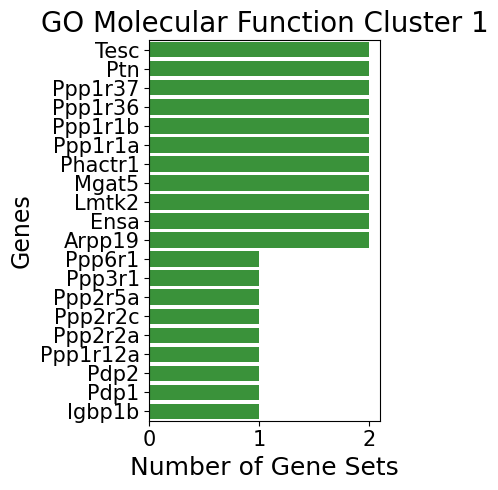

['GOMF_PHOSPHATASE_INHIBITOR_ACTIVITY', 'GOMF_PHOSPHATASE_REGULATOR_ACTIVITY']


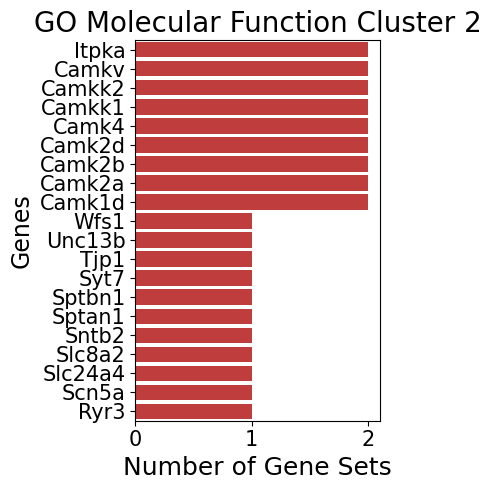

['GOMF_CALMODULIN_DEPENDENT_PROTEIN_KINASE_ACTIVITY', 'GOMF_CALMODULIN_BINDING']


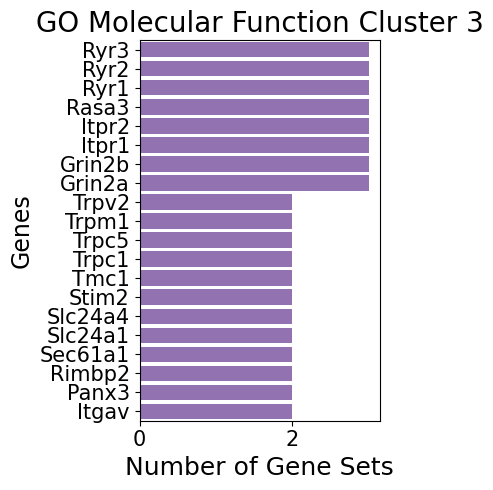

['GOMF_CALCIUM_ION_TRANSMEMBRANE_TRANSPORTER_ACTIVITY', 'GOMF_CALCIUM_CHANNEL_ACTIVITY', 'GOMF_LIGAND_GATED_CALCIUM_CHANNEL_ACTIVITY']


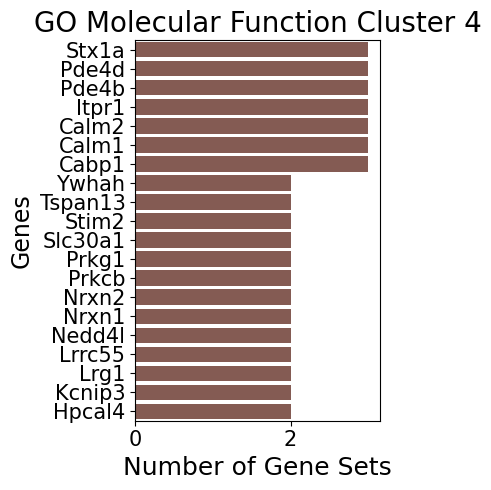

['GOMF_CALCIUM_CHANNEL_REGULATOR_ACTIVITY', 'GOMF_TRANSMEMBRANE_TRANSPORTER_BINDING', 'GOMF_TRANSPORTER_REGULATOR_ACTIVITY']


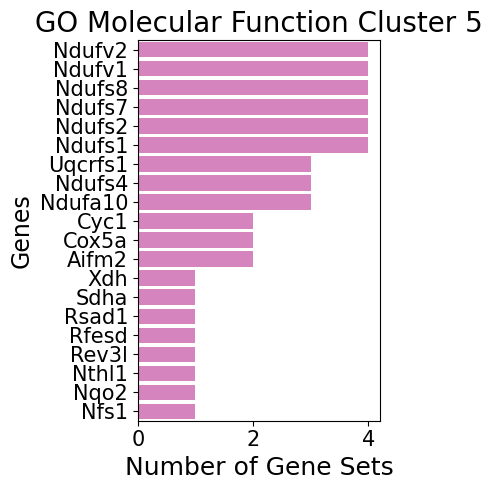

['GOMF_OXIDOREDUCTION_DRIVEN_ACTIVE_TRANSMEMBRANE_TRANSPORTER_ACTIVITY', 'GOMF_ELECTRON_TRANSFER_ACTIVITY', 'GOMF_OXIDOREDUCTASE_ACTIVITY_ACTING_ON_NAD_P_H_QUINONE_OR_SIMILAR_COMPOUND_AS_ACCEPTOR', 'GOMF_METAL_CLUSTER_BINDING']


In [ ]:
generate_leading_edge_report(gomf_out, gomf_res.loc[gomf_res["FDR q-val"] < 0.02]["Term"], gomf_res, "GO Molecular Function")

For the GO MF leading edge analysis, the orange cluster contains Smad binding-related pathways, which are involved in regulating transcriptional activity. The Smad signaling cascade is also activated by transforming growth factor-beta (TGF-B) signaling, which is involved in a diverse set of pathways in neurons.

The red cluster only has two gene sets, but we can see that the key genes in calmodulin/CaMK activity, are the CaMKs as well as CaMK kinases (CaMKKs), which phosphorylate and activate CaMKs.

The purple cluster describes the various calcium channels and receptors involved in activating the intracellular signaling pathways that lead to dendritic growth. Aligning with the results from Reactome, Grin2a and Grin2b code for subunits of the NMDA receptor, which mediates calcium influx into the cytosol and activates CaMK signaling. The other genes include Itpr1,2 and Ryr1,2,3. These genes code for inositol 1,4,5-trisphosphate receptors (IP3Rs) and ryanodine receptors (RyRs), which particpate in another form of calcium signaling. As mentioned briefly in the leading-edge analysis for Reactome, extracellular signals such as glutamate can activate intracellular calcium release from the endoplasmic reticulum (ER) (which forms a network that extends throughout the cell and dendrites in neurons). IP3 is produced by the PLC-B and IP3/DAG signaling pathway and can activate IP3Rs on the ER membrane, leading to calcium release from the ER lumen into the cytosol. The released calcium can then successively activate other IP3Rs as well as RyRs, propagating calcium waves through the cell and to the soma. This calcium could potentially activate CaMK or MAPK/ERK signaling, such as local branch remodeling via CaMKII or CaMKIV signaling in the soma-nucleus region leading to phosphorylation of CREB. Although not shown in the diagram below, CaMKI (one of the genes in the red cluster, Camk1d) also can activate the extracellular signal-regulated kinase ERK (Mapk1), also leading to CREB phosphorylation. CREB then promotes transcription of dendritic growth genes. CREB itself has a well known role in neuronal plasticity and memory formation.


![](https://github.com/rcs-science-research/Dendritic-Branching-GSEA/blob/main/Supplementary%20Materials%20and%20Images/Graphical%20Abstract%20Final%20Version.jpeg?raw=true)

##GO Cellular Component

Finally, we'll quickly run the analysis with GO Cellular Component to confirm some of our previous results.

In [ ]:
gocc_out = gp.prerank(rnk=corrs, gene_sets=msigdb.get_gmt(category="m5.go.cc", dbver="2024.1.Mm"))
gocc_res = gocc_out.res2d.sort_values(by="NES",ascending=False).reset_index(drop=True) #Sorting by NES

2025-05-22 13:34:47,925 [WARNING] Duplicated values found in preranked stats: 4.24% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [ ]:
gocc_res.head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GOCC_NEURON_SPINE,0.565793,2.210407,0.0,0.0,0.0,82/210,11.40%,Nrgn;Nlgn1;Ptk2b;Itpka;Hpca;Atp2b1;Epha4;Baiap...
1,prerank,GOCC_SCHAFFER_COLLATERAL_CA1_SYNAPSE,0.575473,2.188541,0.0,0.0,0.0,61/149,11.31%,Ptprd;Ptk2b;Epha4;Baiap2;Ppp3ca;Stx1a;Gsg1l;It...
2,prerank,GOCC_POSTSYNAPTIC_SPECIALIZATION,0.528282,2.177325,0.0,0.0,0.0,169/450,12.56%,Nlgn1;Ptk2b;Arhgap32;Epha4;Cnksr2;Kalrn;Baiap2...
3,prerank,GOCC_SITE_OF_POLARIZED_GROWTH,0.541934,2.136917,0.0,0.000219,0.001,68/211,8.93%,Ptk2b;Cobl;Epha4;Lamp5;Olfm1;Boc;Rtn4r;Erc2;Sh...
4,prerank,GOCC_RIBBON_SYNAPSE,0.701379,2.12734,0.0,0.000176,0.001,15/31,10.43%,Atp2b1;Otof;Atp2b2;Unc13b;Iqsec2;Cplx3;Lrrtm4;...
5,prerank,GOCC_NEURON_TO_NEURON_SYNAPSE,0.515561,2.1266,0.0,0.000146,0.001,174/467,12.56%,Ptprd;Nlgn1;Ptk2b;Bdnf;Arhgap32;Epha4;Cnksr2;K...
6,prerank,GOCC_POSTSYNAPTIC_SPECIALIZATION_MEMBRANE,0.533421,2.065804,0.0,0.000878,0.006,67/178,11.40%,Nlgn1;Cnksr2;Nptx2;Dlg1;Olfm1;Stx1a;Lzts1;Gsg1...
7,prerank,GOCC_CYTOSOLIC_LARGE_RIBOSOMAL_SUBUNIT,0.594137,2.048244,0.0,0.000878,0.007,45/65,29.89%,Rpl41;Rplp2;Rpl31;Rpl9;Rpl37a;Rpl32;Rpl36;Rpl1...
8,prerank,GOCC_SARCOMERE,0.512418,2.028437,0.0,0.00078,0.007,45/202,8.15%,Igfn1;Fhl2;Ppp3ca;Actn1;Myh7;Homer1;Fhod3;Fkbp...
9,prerank,GOCC_CYCLIN_DEPENDENT_PROTEIN_KINASE_HOLOENZYM...,0.604366,2.026808,0.0,0.000878,0.009,21/54,14.34%,Cdk14;Cdk5r1;Cdkn1a;Ccnjl;Rb1;Ccnd1;Ccng1;Pcna...


As expected, wee see many neuron specific results, such as NEURON_SPINE or POSTSYNAPTIC_SPECIALIZATION. Another gene set is the CYTOSOLIC_LARGE_RIBSOMAL_SUBUNIT, which may correspond to the 3-4 gene sets related to mRNA translation and NMD in the Reactome results. We also see some more specific results related to the actin cytoskeleton, which is important for dendritic branch structure, and cellular anatomical features, like FILOPODIUM_TIP. There also many muscle-related pathways like SARCOMERE, CONTRACTILE_MUSCLE_FIBER, MYOFILAMENT, etc. which likely reflects similar actin cytoskeletal dynamics between muscles and dendritic branching in neurons.

In [ ]:
gocc_res.tail(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
463,prerank,GOCC_PROTEIN_FOLDING_CHAPERONE_COMPLEX,-0.463449,-1.708013,0.0,0.05532,0.507,18/36,27.01%,Cct8;Ccdc47;Cct7;Hsp90ab1;Stip1;Cct3;Psmg1;Ruv...
464,prerank,GOCC_VACUOLAR_MEMBRANE,-0.33791,-1.720634,0.0,0.052356,0.474,82/264,17.92%,Atp6ap2;Laptm4b;Mitf;Tm6sf1;Atp13a2;Rpn2;Slc7a...
465,prerank,GOCC_LYTIC_VACUOLE_MEMBRANE,-0.338233,-1.724126,0.0,0.053302,0.463,65/210,17.92%,Atp6ap2;Laptm4b;Mitf;Tm6sf1;Atp13a2;Slc7a14;Ap...
466,prerank,GOCC_RETROMER_COMPLEX,-0.542867,-1.729405,0.003125,0.053861,0.451,10/20,19.44%,Snx8;Magel2;Vps35;Dctn1;Vps29;Tbc1d5;Dennd5a;A...
467,prerank,GOCC_PEPTIDASE_COMPLEX,-0.374133,-1.750783,0.0,0.049014,0.407,35/116,13.49%,Ube3a;Psmd4;Capn2;Arxes1;Mbl2;Psmd12;Arxes2;Ps...
468,prerank,GOCC_COPI_COATED_VESICLE_MEMBRANE,-0.594225,-1.769659,0.013736,0.045499,0.366,11/16,21.67%,Copg1;Kdelr1;Arcn1;Copa;Cope;Scyl1;Golga5;Copb...
469,prerank,GOCC_LYTIC_VACUOLE,-0.317003,-1.778107,0.0,0.045116,0.345,131/500,14.13%,Atp6ap2;Laptm4b;Gaa;Psap;Mitf;App;Tm6sf1;Atp13...
470,prerank,GOCC_NUCLEOID,-0.452956,-1.790219,0.0,0.044564,0.325,30/46,34.97%,Atad3a;Fastkd2;Slc25a5;Dna2;Acadvl;Hspa9;Tufm;...
471,prerank,GOCC_CYTOCHROME_COMPLEX,-0.502697,-1.812305,0.003521,0.037916,0.265,11/33,11.12%,Cyc1;Uqcrc1;Cox6a2;Cox7b;Uqcrb;Uqcrc2;Uqcr10;C...
472,prerank,GOCC_ORGANELLE_MEMBRANE_CONTACT_SITE,-0.47971,-1.815657,0.0,0.039436,0.254,15/42,10.38%,Tmx2;Canx;Tmx1;Gramd1a;Sacm1l;Clstn3;Tmem41b;B...


Like our other gene set collections, mitchondrial pathways are the most negatively correlated. I'll explain this in the concluding section.

###GO CC Leading Edge Analysis

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/me

Score: 0.04545770103254068, threshold: 0.17553191489361702
Score: 0.09037282297315846, threshold: 0.19402985074626866
Score: 0.1134130772104466, threshold: 0.23728813559322035
Score: 0.12397331065001935, threshold: 0.3617021276595745
Score: 0.15860003116330684, threshold: 0.39284369114877593
Score: 0.19330472126286585, threshold: 0.4
Score: 0.1877655027977884, threshold: 0.5140252454417953
Score: 0.20917848038428125, threshold: 0.5356715766963519
Score: 0.24510696294596773, threshold: 0.6587885154061625
Score: 0.2007179506041906, threshold: 0.667744034587536
Score: 0.2106507102369104, threshold: 0.7794117647058824
Score: 0.20383279422790768, threshold: 0.8109923456215776
Score: 0.2083601084085002, threshold: 0.84
Score: 0.2070634143251041, threshold: 0.8495178755576834
Score: 0.2104812819280851, threshold: 0.8780487804878049
Score: 0.20136037629435388, threshold: 0.885922701640132
Score: 0.20726612862180083, threshold: 0.9028870587339645
Score: 0.1937427867680426, threshold: 0.90407762

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
<ipython-input-24-fc72798bb74f>:21: SettingWithCop

Score: 0.10094786190415422, threshold: 0.9842282843857628
Score: 0.0919744810050171, threshold: 0.996078431372549
Score: 0.09073861602949435, threshold: 0.9979876622615168
Score: 0.08957802998937467, threshold: 0.9982296061211481
Score: 0.0887138637995315, threshold: 0.9988183629170843
OPTIMAL - Score: 0.24510696294596773, threshold: 0.6587885154061625
_____________________________
['GOCC_INNER_MITOCHONDRIAL_MEMBRANE_PROTEIN_COMPLEX', 'GOCC_MITOCHONDRIAL_PROTEIN_CONTAINING_COMPLEX', 'GOCC_RESPIRASOME', 'GOCC_NADH_DEHYDROGENASE_COMPLEX', 'GOCC_OXIDOREDUCTASE_COMPLEX']
Average NES: -2.453982718772984
Cluster Size: 5
_____________________________
['GOCC_SARCOMERE', 'GOCC_CONTRACTILE_MUSCLE_FIBER', 'GOCC_I_BAND']
Average NES: 1.9930350451410517
Cluster Size: 3
_____________________________
['GOCC_RIBBON_SYNAPSE', 'GOCC_PHOTORECEPTOR_RIBBON_SYNAPSE']
Average NES: 2.051962753180394
Cluster Size: 2
_____________________________
['GOCC_POSTSYNAPTIC_SPECIALIZATION', 'GOCC_NEURON_TO_NEURON_SYNAP

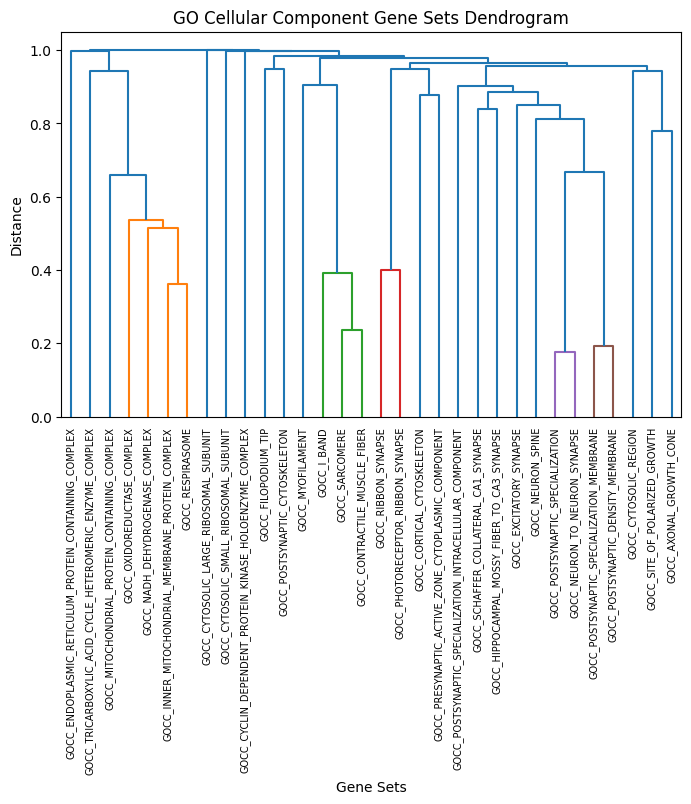

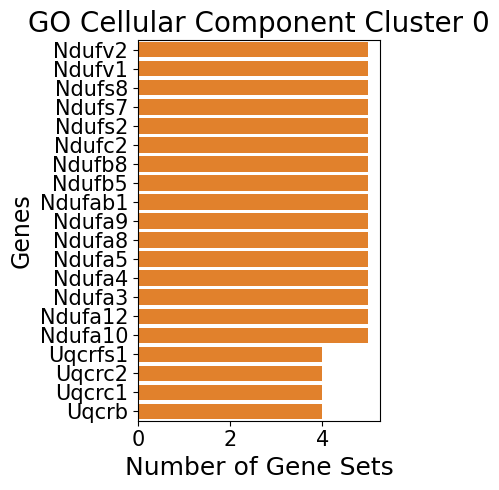

['GOCC_INNER_MITOCHONDRIAL_MEMBRANE_PROTEIN_COMPLEX', 'GOCC_MITOCHONDRIAL_PROTEIN_CONTAINING_COMPLEX', 'GOCC_RESPIRASOME', 'GOCC_NADH_DEHYDROGENASE_COMPLEX', 'GOCC_OXIDOREDUCTASE_COMPLEX']


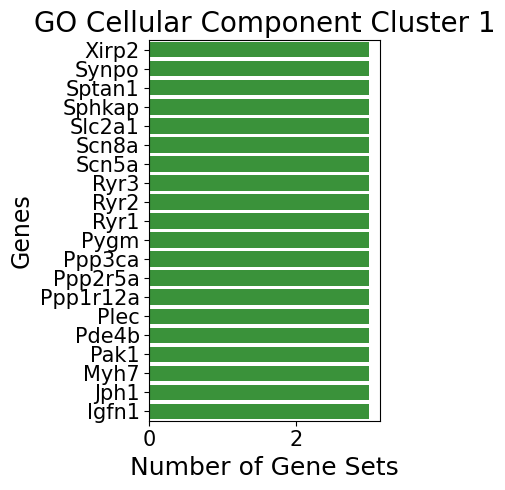

['GOCC_SARCOMERE', 'GOCC_CONTRACTILE_MUSCLE_FIBER', 'GOCC_I_BAND']


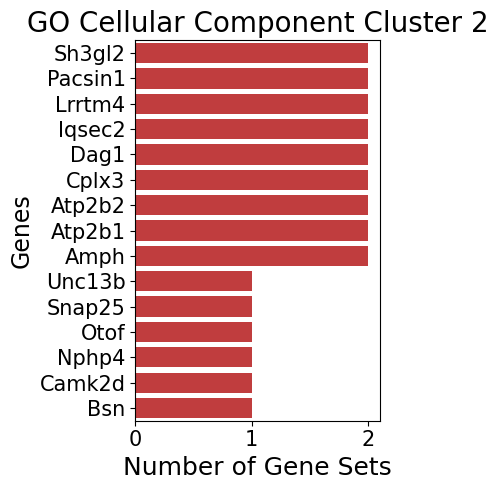

['GOCC_RIBBON_SYNAPSE', 'GOCC_PHOTORECEPTOR_RIBBON_SYNAPSE']


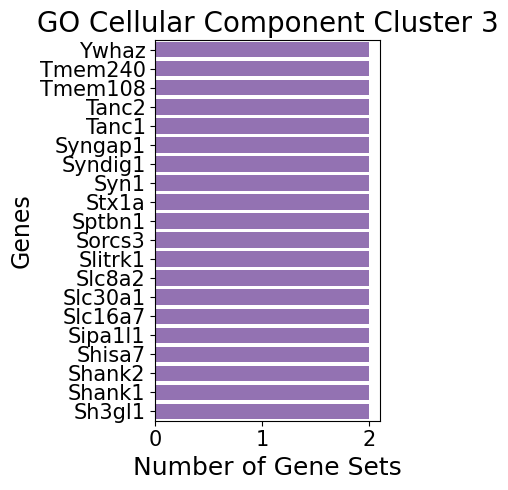

['GOCC_POSTSYNAPTIC_SPECIALIZATION', 'GOCC_NEURON_TO_NEURON_SYNAPSE']


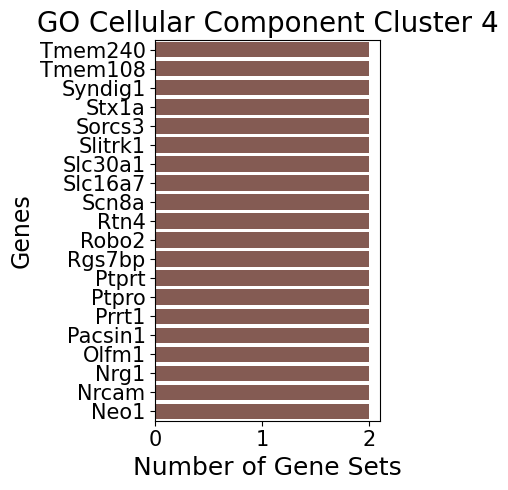

['GOCC_POSTSYNAPTIC_SPECIALIZATION_MEMBRANE', 'GOCC_POSTSYNAPTIC_DENSITY_MEMBRANE']


In [ ]:
generate_leading_edge_report(gocc_out, gocc_res.loc[gocc_res["FDR q-val"] < 0.01]["Term"], gocc_res, "GO Cellular Component")

#Conclusions

All in all, these results suggest that calcium signaling has a central role in regulating dendritic growth. The enrichment of NMDAR pathways suggests that activation of signaling cascades downstream of NMDAR calcium influx, including CaMK and Ras/MAPK signaling, are critical for dendritic arborization. By analyzing the gene frequency in the leading-edge clusters, we consistently identified genes like calmodulin, CaMKII, and CaMKIV, supporting previous evidence that CaMKII modulates local branch dynamics via cytoskeletal changes, whereas CaMKIV induces dendritic growth through CREB phosphorylation (Konur & Ghosh, 2005; Wu et al., 2001). Ras/MAPK signaling, which activates CREB (Wu et al., 2001), also occurred. Furthermore, we also identified evidence for  intracellular calcium release mediated by IP3R and RyRs as another form of calcium signaling that promotes dendritic growth. Transcription factor binding and mRNA translation gene sets were also correlated in the Reactome and GO Molecular Function results, suggesting that CaMK, Ras/MAPK, and IP3/DAG signaling converge in nuclear activation of transcriptional programs that promote dendritic growth.

Interestingly, cellular respiration/mitochondrial gene sets were consistently the most negatively associated, suggesting that mitochondria and cellular respiration somehow downregulates dendritic branching mechanisms. Kimura and Murakami (2014) demonstrated that depleting mitochondria from the dendrites increased apical dendrite branching in developing mouse neurons. They hypothesized that mitochondrial calcium buffering, which would prevent large local increases in cytosolic calcium levels, could downregulate mechanisms like the CaMK, MAPK, or IP3R signaling. However, other research has suggested a positive association between mitochondria and dendritic branching, which may arise from differences in neuronal developmental stages, or modification of mitochondrial function. In those studies, the experimental modification lead to mitochondrial dysfunction and cell death, whereas Kimura and Murakami only altered the distribution by causing mitochondria to migrate from branches and aggregate the soma. This suggests further investigation of mitochondrial calcium buffering’s role in dendrite branching is needed (Li et al., 2004; Chen et al., 2007; Ishihara et al., 2009; Kimura & Murakami, 2014).

Dysregulated dendritic arborization and defects in dendrite morphology are implicated in Alzheimer’s disease, schizophrenia, and a myriad of other pathologies (Kulkarni & Firestein, 2012). This research not only advances our understanding of how neuronal signaling regulates morphology, but may also help identify new therapeutic targets for the treatment of neurological diseases.


#Appendix and Supplementary Information

##Biocarta

In [ ]:
biocarta_out = gp.prerank(rnk=corrs, gene_sets=msigdb.get_gmt(category="m2.cp.biocarta", dbver="2024.1.Mm"))
biocarta_res = biocarta_out.res2d.sort_values(by="NES",ascending=False).reset_index(drop=True) #Sorting by NES

2025-05-22 13:00:38,217 [WARNING] Duplicated values found in preranked stats: 4.24% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [ ]:
biocarta_res.head(20)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,BIOCARTA_NOS1_PATHWAY,0.728747,1.952748,0.0,0.024732,0.016,8/19,4.71%,Ppp3ca;Grin2a;Calm1;Grin2b;Calm3;Prkcb;Prkca;P...
1,prerank,BIOCARTA_AT1R_PATHWAY,0.6806,1.94945,0.0,0.01374,0.018,14/25,12.56%,Ptk2b;Calm1;Calm3;Map2k1;Mapk1;Egfr;Pak1;Prkcb...
2,prerank,BIOCARTA_BIOPEPTIDES_PATHWAY,0.653899,1.927744,0.0,0.011908,0.024,11/28,13.28%,Ptk2b;Calm1;Calm3;Map2k1;Mapk1;Prkcb;Prkca;Jak...
3,prerank,BIOCARTA_PYK2_PATHWAY,0.668721,1.92385,0.001473,0.009275,0.025,12/25,12.56%,Ptk2b;Calm1;Calm3;Map2k1;Mapk1;Pak1;Prkcb;Prkc...
4,prerank,BIOCARTA_CCR5_PATHWAY,0.737855,1.908293,0.003145,0.009068,0.03,9/16,8.67%,Ptk2b;Calm1;Calm3;Cxcl12;Prkcb;Ccl2;Prkca;Gnaq...
5,prerank,BIOCARTA_HDAC_PATHWAY,0.672731,1.901233,0.0,0.008702,0.035,8/23,2.25%,Ppp3ca;Calm1;Camk2a;Igf1r;Avp;Ywhah;Calm3;Pik3r1
6,prerank,BIOCARTA_NKCELLS_PATHWAY,0.716477,1.888838,0.0,0.008637,0.041,6/17,10.47%,Ptk2b;Map2k1;Pik3r1;Pak1;Syk;Ptpn6
7,prerank,BIOCARTA_CALCINEURIN_PATHWAY,0.704797,1.839093,0.0,0.015629,0.079,8/17,6.27%,Ppp3ca;Calm1;Cdkn1a;Calm3;Prkcb;Prkca;Gnaq;Marcks
8,prerank,BIOCARTA_GH_PATHWAY,0.616898,1.812541,0.004161,0.021679,0.116,12/27,12.56%,Map2k1;Pik3r1;Mapk1;Srf;Prkcb;Prkca;Jak2;Ghr;S...
9,prerank,BIOCARTA_CXCR4_PATHWAY,0.668134,1.799463,0.001534,0.023908,0.134,8/19,5.97%,Ptk2b;Map2k1;Cxcl12;Pik3r1;Mapk1;Prkcb;Prkca;Gnaq


In [ ]:
biocarta_res.tail(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
104,prerank,BIOCARTA_COMP_PATHWAY,0.248354,0.650316,0.895312,0.911187,1.0,8/16,30.00%,Masp2;Vps33a;C1ra;C7;C1qa;C1s1;C1qb;Mbl1
105,prerank,BIOCARTA_RELA_PATHWAY,-0.263638,-0.770061,0.775676,0.809425,1.0,4/15,10.73%,Ripk1;Nfkb1;Tradd;Tnfrsf1b
106,prerank,BIOCARTA_INFLAM_PATHWAY,-0.25094,-0.782459,0.793846,0.892313,1.0,1/19,0.43%,Tgfb3
107,prerank,BIOCARTA_ATRBRCA_PATHWAY,-0.263069,-0.824663,0.761329,0.939593,1.0,4/19,20.26%,Atr;Brca1;Rad17;Fancc
108,prerank,BIOCARTA_TOLL_PATHWAY,-0.286522,-0.964033,0.490566,0.753492,1.0,4/24,7.65%,Map3k1;Map2k4;Map3k14;Nfkb1
109,prerank,BIOCARTA_CERAMIDE_PATHWAY,-0.356233,-1.130798,0.280255,0.49616,0.991,9/22,15.99%,Map3k1;Nsmaf;Map2k4;Aifm1;Ripk1;Nfkb1;Tradd;Ra...
110,prerank,BIOCARTA_MTA3_PATHWAY,-0.367912,-1.177297,0.251572,0.517163,0.984,6/19,15.94%,Esr1;Tuba8;Tuba1b;Gapdh;Snai2;Hspb1
111,prerank,BIOCARTA_NFKB_PATHWAY,-0.426224,-1.395929,0.06686,0.24994,0.825,6/21,10.73%,Map3k1;Ripk1;Map3k14;Nfkb1;Tradd;Tnfrsf1b
112,prerank,BIOCARTA_STRESS_PATHWAY,-0.457079,-1.518029,0.036697,0.196855,0.637,8/24,10.68%,Tank;Map3k1;Map2k4;Map4k2;Ripk1;Map3k14;Nfkb1;...
113,prerank,BIOCARTA_TNFR2_PATHWAY,-0.626914,-1.846824,0.0,0.035683,0.116,7/16,10.73%,Traf3;Tank;Map3k1;Ripk1;Map3k14;Nfkb1;Tnfrsf1b


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/me

Score: 0.08489795918367346, threshold: 0.14285714285714285
Score: 0.08518518518518518, threshold: 0.3973214285714286
Score: 0.09074074074074075, threshold: 0.5
Score: 0.11320346320346322, threshold: 0.5227272727272727
Score: 0.1270562770562771, threshold: 0.5454545454545454
Score: 0.13475029915155462, threshold: 0.5763888888888888
Score: 0.14235155424495008, threshold: 0.6363636363636364
Score: 0.10801385637230053, threshold: 0.6658470546338193
Score: 0.1318125435834873, threshold: 0.6666666666666666
Score: 0.1520644016834762, threshold: 0.7411764705882353
Score: 0.13079364686982958, threshold: 0.7660288541867489
Score: 0.14231130289959953, threshold: 0.8349905340617415
Score: 0.23471746405182933, threshold: 0.8758295249245476
OPTIMAL - Score: 0.23471746405182933, threshold: 0.8758295249245476
_____________________________
['BIOCARTA_NOS1_PATHWAY', 'BIOCARTA_AT1R_PATHWAY', 'BIOCARTA_BIOPEPTIDES_PATHWAY', 'BIOCARTA_PYK2_PATHWAY', 'BIOCARTA_CCR5_PATHWAY', 'BIOCARTA_HDAC_PATHWAY', 'BIOCAR

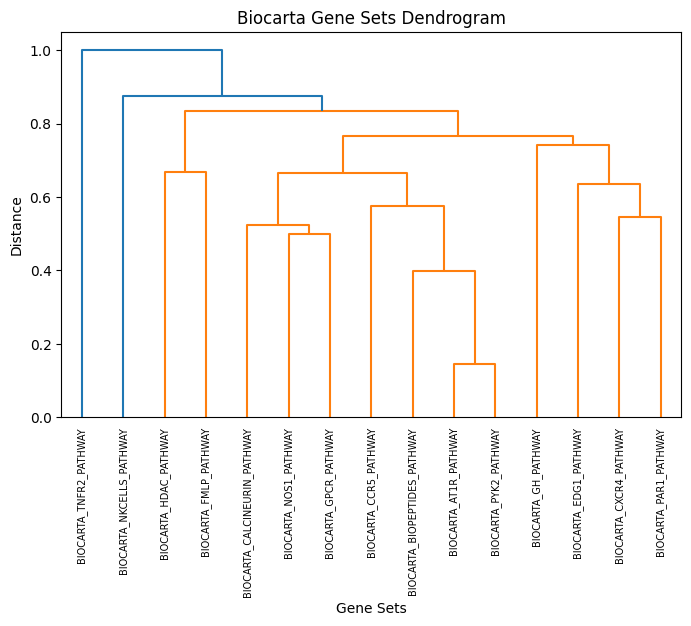

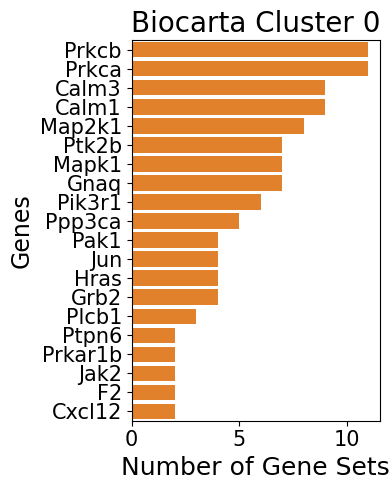

['BIOCARTA_NOS1_PATHWAY', 'BIOCARTA_AT1R_PATHWAY', 'BIOCARTA_BIOPEPTIDES_PATHWAY', 'BIOCARTA_PYK2_PATHWAY', 'BIOCARTA_CCR5_PATHWAY', 'BIOCARTA_HDAC_PATHWAY', 'BIOCARTA_NKCELLS_PATHWAY', 'BIOCARTA_CALCINEURIN_PATHWAY', 'BIOCARTA_GH_PATHWAY', 'BIOCARTA_CXCR4_PATHWAY', 'BIOCARTA_GPCR_PATHWAY', 'BIOCARTA_EDG1_PATHWAY', 'BIOCARTA_PAR1_PATHWAY', 'BIOCARTA_FMLP_PATHWAY']


In [ ]:
generate_leading_edge_report(biocarta_out, biocarta_res.loc[biocarta_res["FDR q-val"] < 0.05]["Term"], biocarta_res, "Biocarta")

##Enrichr (Conversion Section Unfinished)

Enrichr is a web-based software tool for pathway enrichment analysis and has a large collection of gene set databases and libraries, including Reactome, wikiPathways, GO, and the Kyoto Encyclopedia of Genes and Genomes (KEGG), another well-known database. The databases can be accessed using this:

In [ ]:
gp.get_library_name(organism="Mouse") #Shows all gene set databases

To use the Enrichr libraries, we need to first convert our mouse gene symbols to human ones. The BioMart api allows us to map the genes by orthology. In addition to the corresponding gene id and name, we can also get the orthology type, orthology confidence, and percentage similarity, which will be useful for mapping the genes.



In [ ]:
from gseapy import Biomart
bm = Biomart()
m2h = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name',
                           "hsapiens_homolog_orthology_type",
                           "hsapiens_homolog_orthology_confidence",
                           "hsapiens_homolog_perc_id",
                           ])


Query ERROR: caught BioMart::Exception::Database: Could not connect to mysql database ensembl_mart_113: DBI connect('database=ensembl_mart_113;host=127.0.0.1;port=5316','ensro',...) failed: Can't connect to MySQL server on '127.0.0.1' (111) at /nfs/public/ro/ensweb/live/mart/www_113/biomart-perl/lib/BioMart/Configuration/DBLocation.pm line 98.



In [ ]:
m2h.loc[m2h["external_gene_name"].isin(corrs["gene"])].sample(10) #Getting a random sample of the orthology mapping for genes in our dataset

,ensembl_gene_id,external_gene_name,hsapiens_homolog_ensembl_gene,hsapiens_homolog_associated_gene_name,hsapiens_homolog_orthology_type,hsapiens_homolog_orthology_confidence,hsapiens_homolog_perc_id
20533,ENSMUSG00000040127,Sdr9c7,ENSG00000170426,SDR9C7,ortholog_one2one,1.0,84.6645
29928,ENSMUSG00000061689,Dlgap4,ENSG00000080845,DLGAP4,ortholog_one2one,1.0,96.9758
33930,ENSMUSG00000112937,Gm17746,NaN,NaN,NaN,NaN,NaN
54807,ENSMUSG00000074971,Fibin,ENSG00000176971,FIBIN,ortholog_one2one,1.0,90.7834
4586,ENSMUSG00000083210,Gm14869,NaN,NaN,NaN,NaN,NaN
30080,ENSMUSG00000090173,Fbxw10,ENSG00000171931,FBXW10,ortholog_one2many,1.0,70.9709
20417,ENSMUSG00000089789,Rdh1,ENSG00000139547,RDH16,ortholog_one2many,1.0,74.1325
4529,ENSMUSG00000037148,Arhgap10,ENSG00000071205,ARHGAP10,ortholog_one2one,1.0,91.4758
24881,ENSMUSG00000048000,Gigyf2,ENSG00000204120,GIGYF2,ortholog_one2one,1.0,94.8877
45715,ENSMUSG00000055148,Klf2,ENSG00000127528,KLF2,ortholog_one2one,1.0,87.2881


In [ ]:
x= ((m2h.loc[m2h["external_gene_name"].isin(corrs["gene"])]).loc[(m2h.loc[m2h["external_gene_name"].isin(corrs["gene"])])["hsapiens_homolog_orthology_type"] == "ortholog_one2many"])

In [ ]:
x.head(10)

,ensembl_gene_id,external_gene_name,hsapiens_homolog_ensembl_gene,hsapiens_homolog_associated_gene_name,hsapiens_homolog_orthology_type,hsapiens_homolog_orthology_confidence,hsapiens_homolog_perc_id
608,ENSMUSG00000100032,Gm20817,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
665,ENSMUSG00000100535,Gm20870,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
733,ENSMUSG00000100902,Gm20850,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
908,ENSMUSG00000100240,Gm20820,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.0270
939,ENSMUSG00000099856,Gm20906,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
997,ENSMUSG00000100045,Gm20929,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
1331,ENSMUSG00000100939,Gm28998,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
1343,ENSMUSG00000100645,Gm28576,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
1672,ENSMUSG00000101155,Sly,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775
1714,ENSMUSG00000094570,Gm20931,ENSG00000139351,SYCP3,ortholog_one2many,0.0,27.4775


In [ ]:
m2h.loc[m2h["external_gene_name"].isin(corrs["gene"])]

,count
hsapiens_homolog_orthology_type,
ortholog_one2one,17137
ortholog_many2many,5607
ortholog_one2many,3024


As you can see, there are a few different types of orthologs. A `one2one` type indicates that the gene has only one ortholog in the other species and vice versa. `many2many` indicates that there are multiple orthologs on both sides, which is the result of gene duplication in both species after they diverged.`one2many` indicates that a gene has multiple ortho

In [ ]:

#Gm16367
converted_corrs = pd.merge(corrs, m2h[["external_gene_name", "hsapiens_homolog_associated_gene_name"]], left_on="gene", right_on="external_gene_name", how="left")
converted_corrs = converted_corrs.drop(columns=["external_gene_name"])
converted_corrs

,gene,corr_val,hsapiens_homolog_associated_gene_name
0,Arpp21,0.512190,ARPP21
1,Slc17a7,0.508691,SLC17A7
2,Cacna2d1,0.499428,CACNA2D1
3,Ptprd,0.491913,PTPRD
4,R3hdm1,0.487666,R3HDM1
...,...,...,...
38486,Rab3b,-0.300480,RAB3B
38487,Elavl2,-0.300543,ELAVL2
38488,Grip1,-0.303891,GRIP1
38489,Kcnc2,-0.304194,KCNC2


In [ ]:
converted_corrs.loc[converted_corrs["gene"] == "Zfy1"]

,gene,corr_val,hsapiens_homolog_associated_gene_name
12904,Zfy1,0.022749,ZNF549
12905,Zfy1,0.022749,ZNF552
12906,Zfy1,0.022749,ZNF587B
12907,Zfy1,0.022749,ZNF586
12908,Zfy1,0.022749,ZNF418
12909,Zfy1,0.022749,ZNF584
12910,Zfy1,0.022749,ZNF134
12911,Zfy1,0.022749,ZNF256
12912,Zfy1,0.022749,ZNF154
12913,Zfy1,0.022749,ZNF772


# Works Cited

Aleksander, S., Balhoff, J. P., Carbon, S., J. Michael Cherry, Drabkin, H. J., Ebert, D., Feuermann, M., Gaudet, P., Harris, N. L., Hill, D. P., Lee, R., Mi, H., Sierra, Mungall, C. J., Anushya Muruganujan, Tremayne Mushayahama, Sternberg, P. W., Thomas, P., Van, K. M., & Ramsey, J. (2023). The Gene Ontology Knowledgebase in 2023. Genetics, 224(1). https://doi.org/10.1093/genetics/iyad031

‌Ashburner, M., Ball, C. A., Blake, J. A., Botstein, D., Butler, H., Cherry, J. M., Davis, A. P., Dolinski, K., Dwight, S. S., Eppig, J. T., Harris, M. A., Hill, D. P., Issel-Tarver, L., Kasarskis, A., Lewis, S., Matese, J. C., Richardson, J. E., Ringwald, M., Rubin, G. M., & Sherlock, G. (2000). Gene Ontology: tool for the unification of biology. Nature Genetics, 25(1), 25–29. https://doi.org/10.1038/75556

Chen, H., McCaffery, J. M., & Chan, D. C. (2007). Mitochondrial fusion protects against neurodegeneration in the cerebellum. Cell, 130(3), 548–562. https://doi.org/10.1016/j.cell.2007.06.026

Fang, Z., Liu, X., & Peltz, G. (2022). GSEApy: a comprehensive package for performing gene set enrichment analysis in Python. Bioinformatics, 39(1). https://doi.org/10.1093/bioinformatics/btac757

Feature Extraction — neuron morphology 1.1.7 documentation. (2023). Readthedocs.io. https://neuron-morphology.readthedocs.io/en/latest/feature_extraction.html

Gouwens, N. W., Sorensen, S. A., Baftizadeh, F., Budzillo, A., Lee, B. R., Jarsky, T., Alfiler, L., Baker, K., Barkan, E., Berry, K., Bertagnolli, D., Bickley, K., Bomben, J., Braun, T., Brouner, K., Casper, T., Crichton, K., Daigle, T. L., Dalley, R., & de Frates, R. A. (2020). Integrated Morphoelectric and Transcriptomic Classification of Cortical GABAergic Cells. Cell, 183(4), 935-953.e19. https://doi.org/10.1016/j.cell.2020.09.057

Hagenston, A. M., & Bading, H. (2011). Calcium Signaling in Synapse-to-Nucleus Communication. Cold Spring Harbor Perspectives in Biology, 3(11), a004564–a004564. https://doi.org/10.1101/cshperspect.a004564

Ishihara, N., Nomura, M., Jofuku, A., Kato, H., Suzuki, S. O., Masuda, K., Otera, H., Nakanishi, Y., Nonaka, I., Goto, Y., Taguchi, N., Morinaga, H., Maeda, M., Takayanagi, R., Yokota, S., & Mihara, K. (2009). Mitochondrial fission factor Drp1 is essential for embryonic development and synapse formation in mice. Nature Cell Biology, 11(8), 958–966. https://doi.org/10.1038/ncb1907

‌Kanehisa, M., & Goto, S. (2000). KEGG: Kyoto Encyclopedia of Genes and Genomes. Nucleic Acids Research, 28(1), 27–30. https://doi.org/10.1093/nar/28.1.27

Kimura, T., & Murakami, F. (2014). Evidence That Dendritic Mitochondria Negatively Regulate Dendritic Branching in Pyramidal Neurons in the Neocortex. Journal of Neuroscience, 34(20), 6938–6951. https://doi.org/10.1523/jneurosci.5095-13.2014

Konur, S., & Ghosh, A. (2005). Calcium Signaling and the Control of Dendritic Development. Neuron, 46(3), 401–405. https://doi.org/10.1016/j.neuron.2005.04.022

Kulkarni, V. A., & Firestein, B. L. (2012). The dendritic tree and brain disorders. Molecular and Cellular Neuroscience, 50(1), 10–20. https://doi.org/10.1016/j.mcn.2012.03.005

Li, Z., Okamoto, K.-I., Hayashi, Y., & Sheng, M. (2004). The Importance of Dendritic Mitochondria in the Morphogenesis and Plasticity of Spines and Synapses. Cell, 119(6), 873–887. https://doi.org/10.1016/j.cell.2004.11.003

McAllister, A. K. (2000). Cellular and Molecular Mechanisms of Dendrite Growth. Cerebral Cortex, 10(10), 963–973. https://doi.org/10.1093/cercor/10.10.963

M Orlic-Milacic, Beavers, D., Conley, P., Gong, C., Gillespie, M., Griss, J., Haw, R., Jassal, B., Matthews, L., May, B., Petryszak, R., Eliot Ragueneau, Rothfels, K., Sevilla, C., Shamovsky, V., Stephan, R., Krishna Kumar Tiwari, Thawfeek Varusai, Weiser, J., & Wright, A. (2023). The Reactome Pathway Knowledgebase 2024. Nucleic Acids Research, 52(D1). https://doi.org/10.1093/nar/gkad1025

Redmond, L., Kashani, A. H., & Ghosh, A. (2002). Calcium Regulation of Dendritic Growth via CaM Kinase IV and CREB-Mediated Transcription. Neuron, 34(6), 999–1010. https://doi.org/10.1016/s0896-6273(02)00737-7

Sokal, R., & Michener, C. (1958). A Statistical Method for Evaluating Systematic Relationships. University of Kansas Science Bulletin. https://ia800703.us.archive.org/5/items/cbarchive_33927_astatisticalmethodforevaluatin1902/astatisticalmethodforevaluatin1902.pdf

Subramanian, A., Tamayo, P., Mootha, V. K., Mukherjee, S., Ebert, B. L., Gillette, M. A., Paulovich, A., Pomeroy, S. L., Golub, T. R., Lander, E. S., & Mesirov, J. P. (2005). Gene set enrichment analysis: A knowledge-based approach for interpreting genome-wide expression profiles. Proceedings of the National Academy of Sciences, 102(43), 15545–15550. https://doi.org/10.1073/pnas.0506580102

‌Wong, R. O. L., & Ghosh, A. (2002). Activity-dependent regulation of dendritic growth and patterning. Nature Reviews Neuroscience, 3(10), 803–812. https://doi.org/10.1038/nrn941‌

Wu, G.-Y. ., Deisseroth, K., & Tsien, R. W. (2001). Activity-dependent CREB phosphorylation: Convergence of a fast, sensitive calmodulin kinase pathway and a slow, less sensitive mitogen-activated protein kinase pathway. Proceedings of the National Academy of Sciences, 98(5), 2808–2813. https://doi.org/10.1073/pnas.051634198

‌Wu, T., Hu, E., Xu, S., Chen, M., Guo, P., Dai, Z., Feng, T., Zhou, L., Tang, W., Zhan, L., Fu, X., Liu, S., Bo, X., & Yu, G. (2021). clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation, 2(3), 100141. https://doi.org/10.1016/j.xinn.2021.100141
